# <center>Forecast Future Sales    </center>

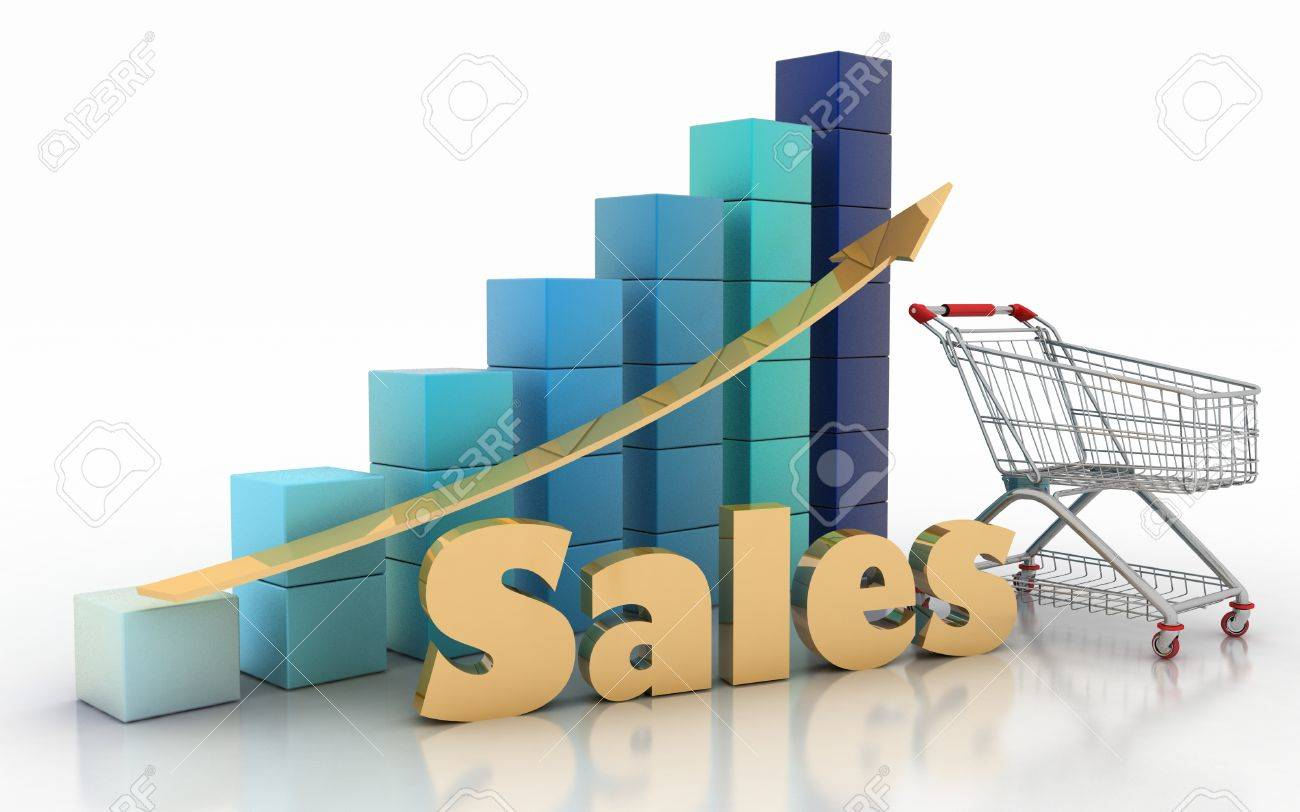

#### The notebook is classified to the following sections:
<a href='#the_destination_1'>1. Problem Statement</a><br>
<a href='#the_destination_2'>2. Import Data</a><br>
-   <a href='#the_destination_2.1'>2.1 Data Dictionary</a><br>

<a href='#the_destination_3'>3. Exploratory Data Analysis (EDA)</a><br>
<a href='#the_destination_4'>4. Exploring the target</a><br>
<a href='#the_destination_5'>5. Detecting Outliers</a><br>
<a href='#the_destination_6'>6. Feature Engineering</a><br>
-   <a href='#the_destination_6.1'>6.1 merging test with train</a><br>

<a href='#the_destination_7'>7 Fill lags missing values</a><br>
<a href='#the_destination_8'>8. visualization</a><br>
<a href='#the_destination_9'>9. Dummies</a><br>

<a href='#the_destination_10'>10. Modeling</a>

   -   <a href='#the_destination_10.1'>10.1 Xgboost</a>

   -   <a href='#the_destination_10.2'>10.2 Sequential model</a>

   -   <a href='#the_destination_10.3'>10.3 LSTM</a>

   -   <a href='#the_destination_10.4'>10.4 Random Forest Regressor Model</a>

   -   <a href='#the_destination_10.5'>10.5 LinearRegression</a>

   -   <a href='#the_destination_10.6'>10.6 Ridge</a>

   -   <a href='#the_destination_10.7'>10.7 Build Logistic Regression Model</a>

          

<a href='#the_destination_11'>11. Submission</a><br>
<a href='#the_destination_13'>12. Evaluation</a><br>
<a href='#the_destination_13'>13. Conclusion and Recommendations</a><br>
<a href='#the_destination_14'>14. References</a><br>

### Install XGBOOST 1.1.0

In [1]:
pip install xgboost --upgrade

Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (1.1.0)


In [2]:
# to check version 
import xgboost as xgb
xgb.__version__

'1.1.0'

<a id='the_destination_1'></a>
# 1. Problem Statement

We are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Notice that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

<br><br><br>**To use tensorflow in CPU uncomment the code below, And for GPU leave it commented**

In [0]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
# import tensorflow as tf

In [0]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

### if you using colab and you want to link your google drive account 

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='the_destination_2'></a>
## import required libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge , Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
import tensorflow as tf
import time

# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


<a id='the_destination_2'></a>
# 2. Importing Datasets

In [0]:
df_sales_train0 = pd.read_csv('/content/drive/My Drive/colab/sales_train.csv')
test = pd.read_csv('/content/drive/My Drive/colab/test.csv')
df_shops = pd.read_csv('/content/drive/My Drive/colab/shops_en.csv')
df_items = pd.read_csv('/content/drive/My Drive/colab/items_en.csv')
df_catog = pd.read_csv('/content/drive/My Drive/colab/item_categories_en.csv')
df = pd.read_csv('/content/drive/My Drive/colab/sample_submission.csv')

<a id='the_destination_2.1'></a>
#### 2.1 Data Dictionary

|Feature|Dataset|Description|
|-------|---|---|
|ID|test|an Id that represents a (Shop, Item) tuple within the test set.| 
|Shop_id|df_shops/test/df_sales_train0|unique identifier of a shop.| 
|item_id|df_items/test/df_sales_train0|unique identifier of a product.| 
|item_category_id |df_catog/df_sales_train0/df_items|unique identifier of item category.| 
|item_cnt_day|df_sales_train0|number of products sold. You are predicting a monthly amount of this measure.| 
|item_price|df_sales_train0|current price of an item.| 
|date|df_sales_train0|date in format dd/mm/yyyy.| 
|date_block_num|df_sales_train0|a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33.| 
|item_name|df_sales_train0/df_items|name of item.|
|shop_name|df_sales_train0/df_shops|name of shop.|
|item_category_name|df_sales_train0/df_catog|name of item category.|

<a id='the_destination_3'></a>
# 3. EDA

In [0]:
display(df_sales_train0.head())
df_sales_train0.shape

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


(2935849, 6)

In [0]:
df_sales_train0['date_block_num'].nunique()

34

In [0]:
df_sales_train0['shop_id'].nunique()

60

In [0]:
df_sales_train0['item_id'].nunique()

21807

In [0]:
df_catog.head()

,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


In [0]:
df_catog['item_category_name'].nunique()

84

In [0]:
df_items.head()

,item_name,item_id,item_category_id
0,! POWER IN glamor (PLAST.) D,0,40
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76
2,*** In the glory (UNV) D,2,40
3,*** BLUE WAVE (Univ) D,3,40
4,*** BOX (GLASS) D,4,40


In [0]:
df_items['item_name'].nunique()

22155

In [0]:
df_shops.head()

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 Franc",0
1,"! Yakutsk TC ""Central"" Franc",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TRC ""October-Kinomir""",3
4,"Volzhsky mall ""Volga Mall""",4


In [0]:
df_shops['shop_name'].nunique()

60

In [0]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [0]:
df.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [0]:
df_sales_train0.shape

(2935849, 6)

<a id='the_destination_4'></a>
# 4. Exploring the target

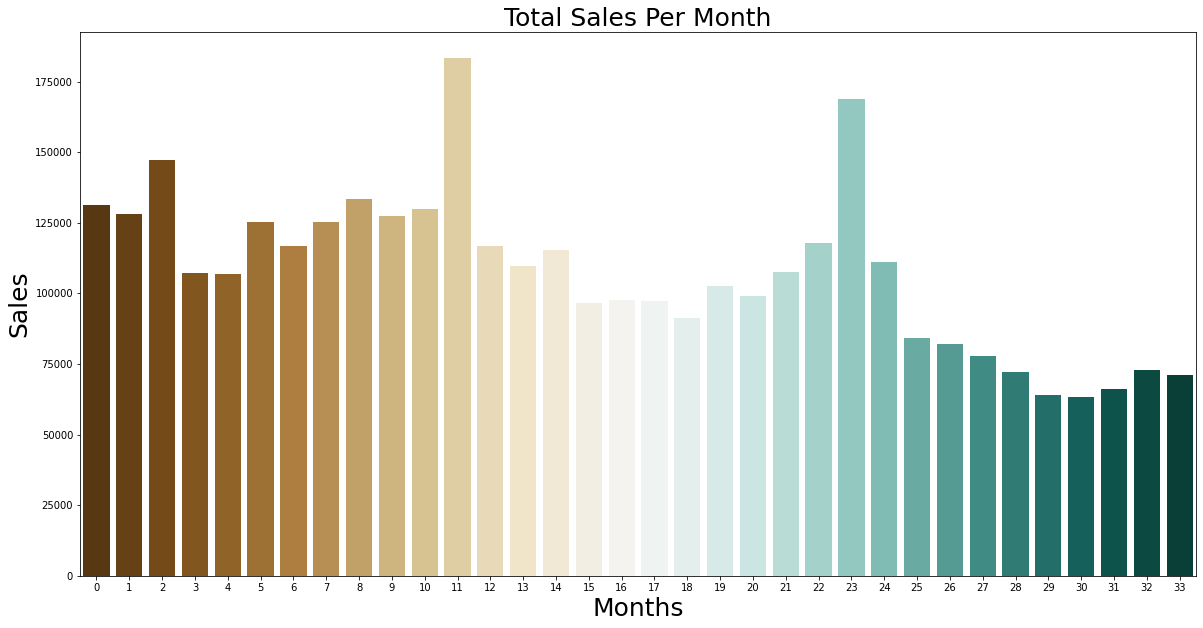

In [0]:
#this figure before filtering train data by taking only item_id and shop_id that exists in the test data  

Z = df_sales_train0.groupby('date_block_num').agg({'item_cnt_day': sum}).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,10))
sns.barplot(data=Z, x='date_block_num', y='item_cnt_day', ax = ax, palette="BrBG")
plt.title('Total Sales Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Sales', fontsize=25);


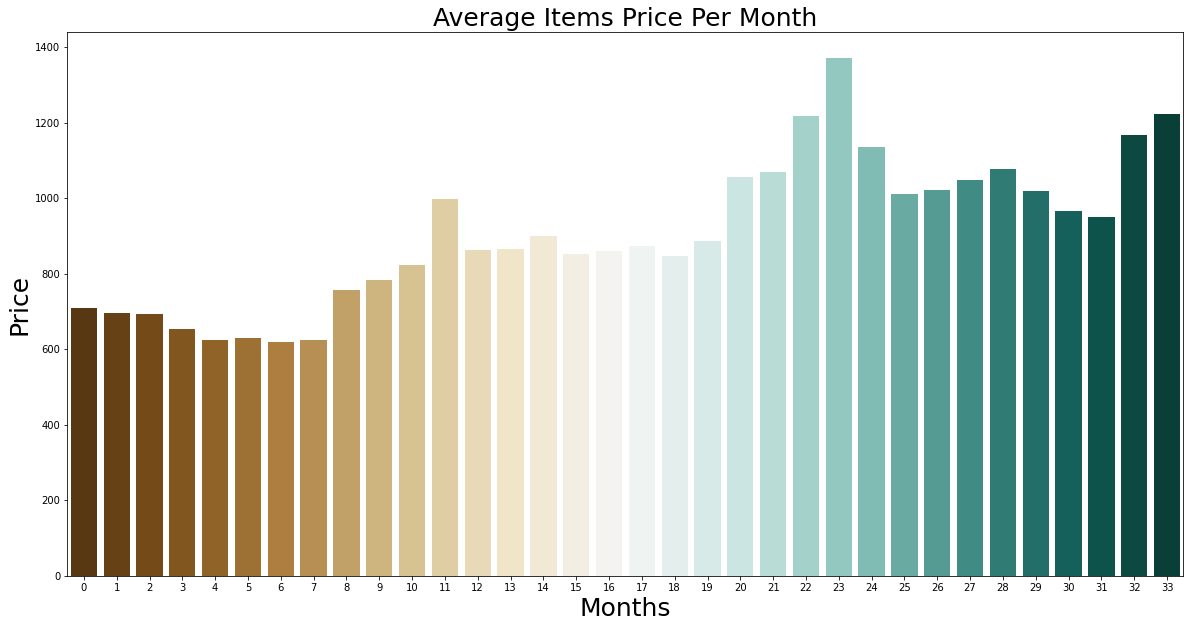

In [0]:
#also this figure before filtering train data by taking only item_id and shop_id that exists in the test data  

price_per_month = df_sales_train0.groupby('date_block_num').agg({'item_price': 'mean'}).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,10))
sns.barplot(data=price_per_month, x='date_block_num', y='item_price', ax = ax, palette="BrBG")
plt.title('Average Items Price Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Price', fontsize=25);

<a id='the_destination_5'></a>
### 5. Detecting Outliers

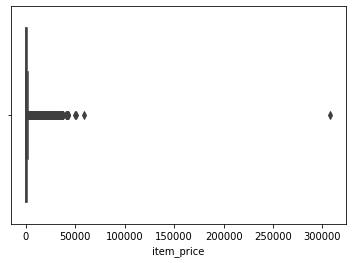

In [0]:
sns.boxplot(df_sales_train0['item_price'])

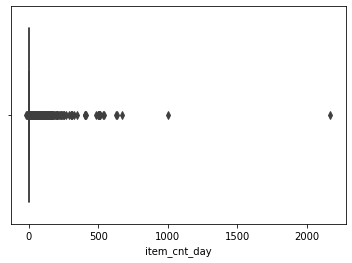

In [0]:
sns.boxplot(df_sales_train0['item_cnt_day'])

In [0]:
#removing item_cnt_day bigger than 1001 and item_price bigger than 100000
df_sales_train0 = df_sales_train0[df_sales_train0['item_cnt_day'] < 1001]
df_sales_train0 = df_sales_train0[df_sales_train0['item_price'] < 100000]

<a id='the_destination_6'></a>

# 6. Feature Engineering

Gathering all combinations of : [date_block_num , shop_id , item_id] because we will transform our data from daily to monthly

In [0]:
from itertools import product
df_sales_train = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = df_sales_train0[df_sales_train0['date_block_num'] == i]
    df_sales_train.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype='int16'))
    
df_sales_train = pd.DataFrame(np.vstack(df_sales_train), columns=cols)

Create a 'revenue' column from multiplying 'item_price' with 'item_cnt_day'

In [0]:
df_sales_train0['revenue'] = df_sales_train0['item_price'] *  df_sales_train0['item_cnt_day']

transform our data from daily to monthly by using grouby 

In [0]:
agg = df_sales_train0.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
agg.columns = ['item_cnt_month']
agg.reset_index(inplace=True)
merge1 = pd.merge(df_sales_train, agg, on=cols, how='left')

Create a 'date_block_num' column in test dataset, And all of it will be 34 because all the test data in the same month 

In [0]:
test['date_block_num'] = 34

<a id='the_destination_6.1'></a>

#### 6.1 merging test with train

Here we are filtering the train data to only keep 'shop_id' and 'item_id' that exist in test data

In [0]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
merge1 = merge1[merge1['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
merge1 = merge1[merge1['item_id'].isin(test_item_ids)]
merge1.reset_index(inplace=True, drop=True)

Here we are merging train and test data 

In [0]:
merge1 = pd.concat([merge1, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
merge1.fillna(0, inplace=True)

Merging our dataframe with shops and items and categories datasets 

In [0]:
merge1 = pd.merge(merge1, df_shops, on=['shop_id'], how='left')
merge1 = pd.merge(merge1, df_items, on=['item_id'], how='left')
merge1 = pd.merge(merge1, df_catog, on=['item_category_id'], how='left')

Correct duplicate values

In [0]:
merge1.loc[merge1.shop_id == 0, 'shop_id'] = 57
merge1.loc[merge1.shop_id == 1, 'shop_id'] = 58
merge1.loc[merge1.shop_id == 10, 'shop_id'] = 11

Because the data in time series structure, Here we are creating a function which will create a lag columns to see how the data changes from time to time

In [0]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [0]:
merge1 = lag_feature(merge1, [1,2,3,6,12], 'item_cnt_month')  # Create months lags

This data gathered from russian stores, So here we are adding a new column 'CPI_inflation' which contains monthly CPI inflation in russia from 2013 to the end of 2015 (CPI: Consumer price index)<br>

In [0]:
CPI_inflation = [0.97,0.56,0.34,0.51,0.66,0.42,0.82,0.14,0.21,0.57,0.57,0.50,
                 0.59,0.70,1.02,0.90,0.90,0.62,0.49,0.24,0.65,0.82,1.28,2.62,
                 3.85,2.22,1.21,0.46,0.35,0.19,0.80,0.35,0.57,0.74,0.75]
merge1['CPI_inflation'] = 0
for i, value in enumerate(CPI_inflation):
    merge1['CPI_inflation'][merge1['date_block_num'] == i ] = value

merge1 = lag_feature(merge1, [1,2,3,6,12], 'CPI_inflation')  # Creating lags for CPI_inflation

Create a new column "date_avg_item_cnt" wich will take the average of all items sales per month

In [0]:
agg = merge1.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
agg.columns = [ 'date_avg_item_cnt' ]
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num'], how='left')
merge1 = lag_feature(merge1, [1], 'date_avg_item_cnt')
# merge1.drop(['date_avg_item_cnt'], axis=1, inplace=True)

Create a new column "date_item_avg_item_cnt" wich will take the average for each item sales per month 

In [0]:
agg = merge1.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
agg.columns = [ 'date_item_avg_item_cnt' ]
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','item_id'], how='left')
merge1 = lag_feature(merge1, [1,2,3,6,12], 'date_item_avg_item_cnt')
# merge1.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

Create a new column "date_shop_avg_item_cnt" wich will take the average for each shop sales per month 

In [0]:
agg = merge1.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
agg.columns = [ 'date_shop_avg_item_cnt' ]
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','shop_id'], how='left')
merge1 = lag_feature(merge1, [1,2,3,6,12], 'date_shop_avg_item_cnt')
# merge1.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)


Create a new column "date_cat_avg_item_cnt" wich will take the average for each category sales per month 

In [0]:
agg = merge1.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
agg.columns = [ 'date_cat_avg_item_cnt' ]
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','item_category_id'], how='left')
merge1 = lag_feature(merge1, [1], 'date_cat_avg_item_cnt')
# merge1.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)


Create a new column "date_shop_cat_avg_item_cnt" wich will take the average for each shop with category sales per month 

In [0]:
agg = merge1.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
agg.columns = ['date_shop_cat_avg_item_cnt']
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
merge1 = lag_feature(merge1, [1], 'date_shop_cat_avg_item_cnt')
# merge1.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)


Create a new column "item_avg_item_price" wich will take the average price for each item 

In [0]:
agg =df_sales_train0.groupby(['item_id']).agg({'item_price': ['mean']})
agg.columns = ['item_avg_item_price']
agg.reset_index(inplace=True)
merge1 = pd.merge(merge1, agg, on=['item_id'], how='left')

Create a new column "date_item_avg_item_price" wich will take the average price for each item per month

In [0]:
agg = df_sales_train0.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
agg.columns = ['date_item_avg_item_price']
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','item_id'], how='left')
lags = [1,2,3,4,5,6]
merge1 = lag_feature(merge1, lags, 'date_item_avg_item_price')

Create a new lag columns which will contains the percent of the difference between average item price in lag months and average price for each item 

In [0]:
for i in lags:
    merge1['delta_price_lag_'+str(i)] = \
        (merge1['date_item_avg_item_price_lag_'+str(i)] - merge1['item_avg_item_price']) / merge1['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
merge1['delta_price_lag'] = merge1.apply(select_trend, axis=1)
merge1['delta_price_lag'].fillna(0, inplace=True)

we don't need all lags columns we create it to get delta here we will drop it 

In [0]:
fetures_to_drop = []
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

merge1.drop(fetures_to_drop, axis=1, inplace=True)


Create a new column "date_shop_revenue" wich will take the sum of revenue for each shop per month

In [0]:
agg = df_sales_train0.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
agg.columns = ['date_shop_revenue']
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['date_block_num','shop_id'], how='left')

Create a new column "date_shop_revenue" wich will take the avreage of revenue for each shop

In [0]:
agg = merge1.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
agg.columns = ['shop_avg_revenue']
agg.reset_index(inplace=True)

merge1 = pd.merge(merge1, agg, on=['shop_id'], how='left')

Create a new lag columns which will contains the percent of the difference between average shop revenue in lag months and sum of revenue for each shop per month

In [0]:
merge1['delta_revenue'] = (merge1['date_shop_revenue'] - merge1['shop_avg_revenue']) / merge1['shop_avg_revenue']

merge1 = lag_feature(merge1, [1], 'delta_revenue')


Create a new column "month" wich will take month number from date_block_num

In [0]:
merge1['month'] = merge1['date_block_num'] % 12

Create a new column "days" wich will take Number of days in a month. 
There are no leap years.



In [0]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
merge1['days'] = merge1['month'].map(days)

Create a new column "item_shop_last_sale" which will count duration since last sale for each item and shop

In [0]:
cache = {}
merge1['item_shop_last_sale'] = -1
for idx, row in merge1.iterrows():    
    key = str(row['item_id'])+' '+str(row['shop_id'])
    if key not in cache:
        if row['item_cnt_month']!=0:
            cache[key] = row['date_block_num']
    else:
        last_date_block_num = cache[key]
        merge1.at[idx, 'item_shop_last_sale'] = row['date_block_num'] - last_date_block_num
        cache[key] = row['date_block_num']  

Create a new column "item_last_sale" which will count duration since last sale for each item

In [0]:
cache = {}
merge1['item_last_sale'] = -1
for idx, row in merge1.iterrows():    
    key = row['item_id']
    if key not in cache:
        if row['item_cnt_month']!=0:
            cache[key] = row['date_block_num']
    else:
        last_date_block_num = cache[key]
        if row['date_block_num']>last_date_block_num:
            merge1.at[idx, 'item_last_sale'] = row['date_block_num'] - last_date_block_num
            cache[key] = row['date_block_num']   

Create a new columns :
-   "item_shop_first_sale" which will count duration since first sale for each item and shop

-   "item_first_sale" which will count duration since first sale for each item 

In [0]:
merge1['item_shop_first_sale'] = merge1['date_block_num'] - merge1.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
merge1['item_first_sale'] = merge1['date_block_num'] - merge1.groupby('item_id')['date_block_num'].transform('min')

This data gathered from russian stores, So here we are adding a new column 'gdp' which contains yearly gdp in russia from 2013 to the end of 2015 (gdp: Gross domestic product)<br>


In [0]:
merge1['gdp'] = 0
merge1['gdp'][merge1['date_block_num'] < 25 ] = 14101
merge1['gdp'][merge1['date_block_num'] > 24 ] = 9314

<a id='the_destination_7'></a>

### 7. Fill lags missing values

In [0]:
merge1.isnull().sum().sum()

21456419

In [0]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
            elif('CPI_inflation' in col):
                df[col].fillna(0, inplace=True)        
    return df

In [0]:
merge1 = fill_na(merge1)

In [0]:
merge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988638 entries, 0 to 2988637
Data columns (total 52 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   date_block_num                    int64  
 1   shop_id                           int64  
 2   item_id                           int64  
 3   item_cnt_month                    float64
 4   ID                                float64
 5   shop_name                         object 
 6   item_name                         object 
 7   item_category_id                  int64  
 8   item_category_name                object 
 9   item_cnt_month_lag_1              float64
 10  item_cnt_month_lag_2              float64
 11  item_cnt_month_lag_3              float64
 12  item_cnt_month_lag_6              float64
 13  item_cnt_month_lag_12             float64
 14  CPI_inflation                     float64
 15  CPI_inflation_lag_1               float64
 16  CPI_inflation_lag_2               fl

all the first words in shop names contains city names so here we will fix spaces and special characters

In [0]:
merge1['shop_name'].unique()

array(['Yaroslavl shopping center "Altair"', 'Moscow TRC "Atrium"',
       'Moscow TK "Budenovsky" (pav.K7)', 'Kursk TC "Pushkin"',
       'Moscow Shop C21', 'Krasnoyarsk SC "June"',
       'Moscow MTRTS "Afi Mall"',
       'Moscow shopping center "MEGA Teply Stan" II of',
       'Moscow shopping mall "area" (Belyaevo)',
       'Volzhsky mall "Volga Mall"', 'Voronezh (Plekhanovskaya, 13)',
       'Adygea TC "Mega"', 'Balashikha TRC "October-Kinomir"',
       'Voronezh TRC "Maksimir"', 'Kolomna TC "Rio"',
       'Kaluga SEC "XXI Century"', 'Zhukovsky Street. Chkalov 39m?',
       'Kazan shopping mall of "Parkhouse" II of',
       'Shop Online Emergencies', 'Ufa TC "Family" 2',
       'Moscow shopping center "Semyonov"',
       'Nizhny Novgorod SEC "Fantasy"', 'Czechs SEC "Carnival"',
       'Surgut SEC "City Mall"', 'Tyumen SC "Goodwin"',
       'St. Petersburg TK "Nevsky Center"', 'Ufa TC "Central"',
       'RostovNaDonu TC "Mega"', 'Omsk TC "Mega"', 'Samara TC "Melody"',
       'Novos

In [0]:
merge1['shop_name'].replace('! Yakutsk Ordzhonikidze, 56 Franc' , 'Yakutsk Ordzhonikidze, 56' , inplace=True) 
merge1['shop_name'].replace('! Yakutsk TC "Central" Franc' , 'Yakutsk TC "Central"' , inplace=True) 
merge1['shop_name'].replace('St. Petersburg TK "Nevsky Center"' , 'Petersburg TK "Nevsky Center"' , inplace=True) 
merge1['shop_name'].replace('Shop Online Emergencies' , 'online Shop Emergencies' , inplace=True) 
merge1['shop_name'].replace('Digital storage 1C-line' , 'online Digital storage 1C-line' , inplace=True)
merge1['shop_name'].replace('Zhukovsky Street. Chkalov 39m?' , 'Zhukovsky Street. Chkalov 39m²' , inplace=True)

Create a new column "city" from the first word in shop names

In [0]:
merge1['city'] = merge1['shop_name'].str.split(' ').map(lambda x: x[0])

Create a new columns : 
 - "category_type" which will extract category_type from item_category_name
 - "category_subtype" which will extract category_subtype from item_category_name

In [0]:
merge1['item_category_name'].unique()

array(['Movies - Blu-Ray', 'Music - CD of local production',
       'Games PC - Standard Edition', 'Music - Vinyl', 'Games - XBOX 360',
       'Books - Methodical materials 1C', 'Program - For home and office',
       'Games - PSP', 'Games - PS3', 'Gifts - Development',
       'Program - 1C: Enterprise 8', 'Music - MP3',
       'Music - Gift Edition', 'Games PC - Additional publications',
       'Accessories - PS3', 'Accessories - PSVita', 'Payment cards - PSN',
       'Music - CD production firm', 'Games - PSVita',
       'Movies - Blu-Ray 3D', 'Accessories - XBOX 360', 'Movie - DVD',
       'Books - Audiobooks 1C', 'Program - Educational',
       'Books - Audiobooks', 'Cinema - Collector', 'Gifts - Souvenirs',
       'Gifts - gadgets, robots, sports', 'System Tools',
       'Gifts - Board Games', 'Gifts - Games (compact)',
       'Gifts - Soft Toys', 'batteries', 'Gifts - Figures',
       'Delivery of goods', "Games PC - Collector's Edition",
       'Gifts - Bags, Albums, Mats d / mo

In [0]:
merge1['split'] = merge1['item_category_name'].str.split('-')
merge1['category_type'] = merge1['split'].map(lambda x: x[0].strip())
merge1['category_subtype'] = merge1['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
merge1.drop(columns=['item_category_name' , 'split'] , inplace=True , axis=1)

fix spelling 

In [0]:
merge1['category_subtype'].replace('Blu','BluRay' , inplace=True)
merge1['category_type'].replace('Movies','Movie' , inplace=True)

In [0]:
merge1['category_type'].unique()

array(['Movie', 'Music', 'Games PC', 'Games', 'Books', 'Program', 'Gifts',
       'Accessories', 'Payment cards', 'Cinema', 'System Tools',
       'batteries', 'Delivery of goods', 'Programs', 'Game consoles',
       'Игры', 'Games Android', 'Payment card', 'PC', 'Games MAC'],
      dtype=object)

In [0]:
merge1['category_subtype'].unique()

array(['BluRay', 'CD of local production', 'Standard Edition', 'Vinyl',
       'XBOX 360', 'Methodical materials 1C', 'For home and office',
       'PSP', 'PS3', 'Development', '1C: Enterprise 8', 'MP3',
       'Gift Edition', 'Additional publications', 'PSVita', 'PSN',
       'CD production firm', 'DVD', 'Audiobooks 1C', 'Educational',
       'Audiobooks', 'Collector', 'Souvenirs', 'gadgets, robots, sports',
       'System Tools', 'Board Games', 'Games (compact)', 'Soft Toys',
       'batteries', 'Figures', 'Delivery of goods', "Collector's Edition",
       'Bags, Albums, Mats d / mouse', 'Attributes', 'Digital',
       'Home & Office (Digital)', 'Educational (figure)',
       'Souvenirs (weighed in)', 'PS4', 'Audiobooks (figure)',
       'Accessories for games', 'Live!', 'Live! (Numeral)', 'XBOX ONE',
       'Comics, Manga', 'artbook, encyclopedia', 'Windows (figure)',
       'MAC (figure)', 'Headsets / Headphones'], dtype=object)

### Saving the data  after we fineshed feature engineering 

In [0]:
# merge1.to_csv('/content/drive/My Drive/colab/merge1_Nodummies.csv')

**Importing the dataset**

In [0]:
merge1 = pd.read_csv('/content/drive/My Drive/colab/merge1_Nodummies.csv' , index_col='Unnamed: 0')

In [0]:
# merge1_Nodummies = pd.read_csv('/content/drive/My Drive/colab/merge1_Nodummies.csv' , index_col='Unnamed: 0')

<a id='the_destination_8'></a>

# 8. Visualization

filter our data to select only sales for visualization

In [0]:
merge1_Nodummies = merge1_Nodummies[merge1_Nodummies['date_block_num'] < 34]
merge1_Nodummies = merge1_Nodummies[merge1_Nodummies['item_cnt_month'] > 0]


Monthly Sales per category type 

In [0]:
import plotly.express as px
pie_fig = merge1_Nodummies.groupby('category_type').agg({'item_cnt_month': sum}).\
sort_values(by='item_cnt_month',ascending=False).reset_index()
fig = px.pie(pie_fig, values='item_cnt_month', names='category_type', title='Percentage of Sales Per Category')
fig.show()

In [0]:
import plotly.express as px
sub_pie = merge1_Nodummies.groupby('category_subtype').agg({'item_cnt_month': sum}).\
sort_values(by='item_cnt_month',ascending=False).reset_index()
fig = px.pie(sub_pie, values='item_cnt_month', names='category_subtype', title='Percentage of Sales Per Sub Category')
fig.show()

--------------------

Monthly Sales per category type 

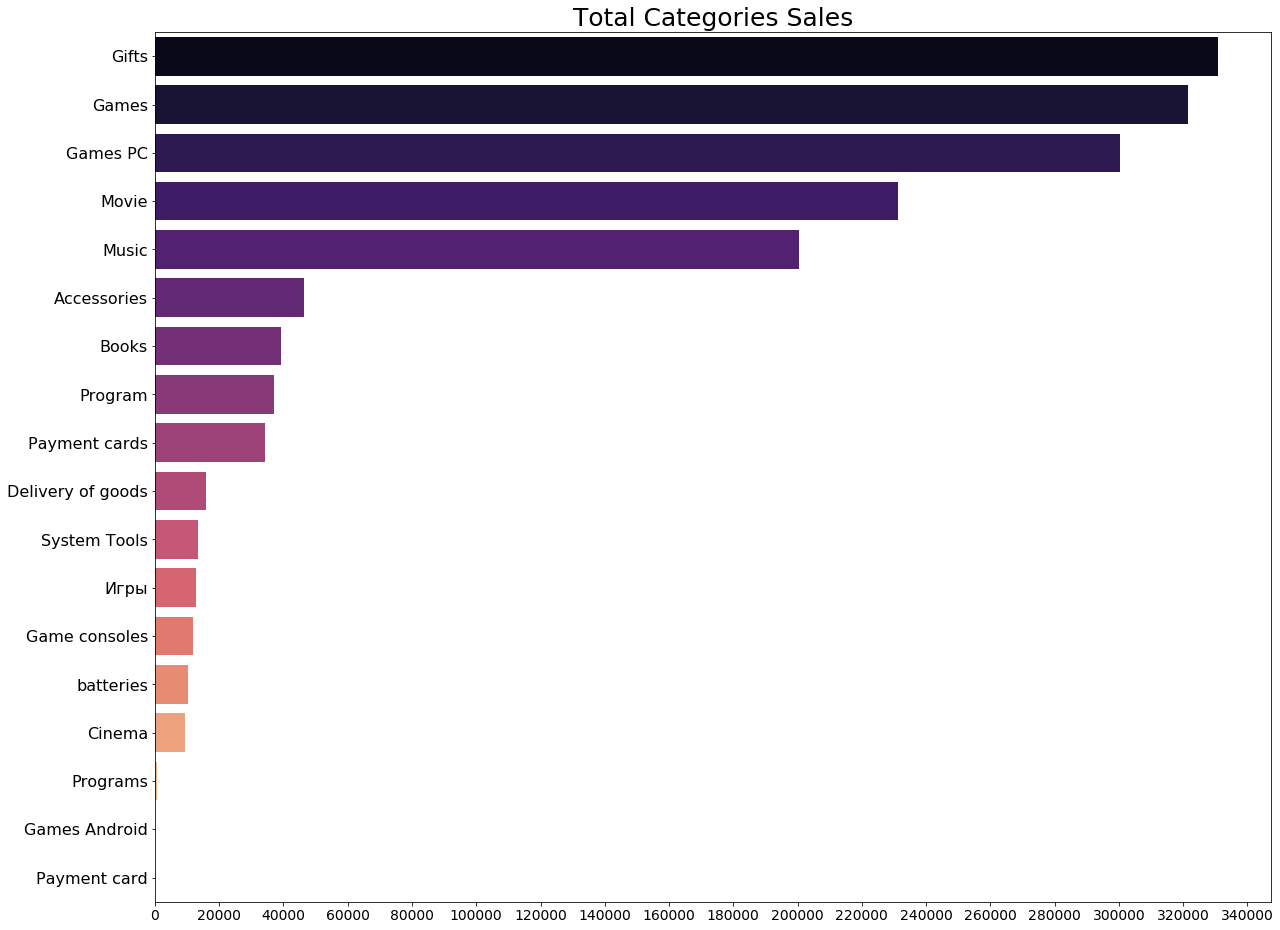

In [0]:
Z = merge1_Nodummies.groupby('category_type').agg({'item_cnt_month': sum}).sort_values(by='item_cnt_month',ascending=False).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,16))
sns.barplot(data=Z, x='item_cnt_month', y='category_type', palette="magma",orient='h')
plt.yticks()
plt.ylabel('')
plt.xlabel('')
plt.title('Total Categories Sales', fontsize=25)
plt.xticks([i for i in range(0, 350000, 20000)], fontsize=14);

Monthly Sales per category subtype 

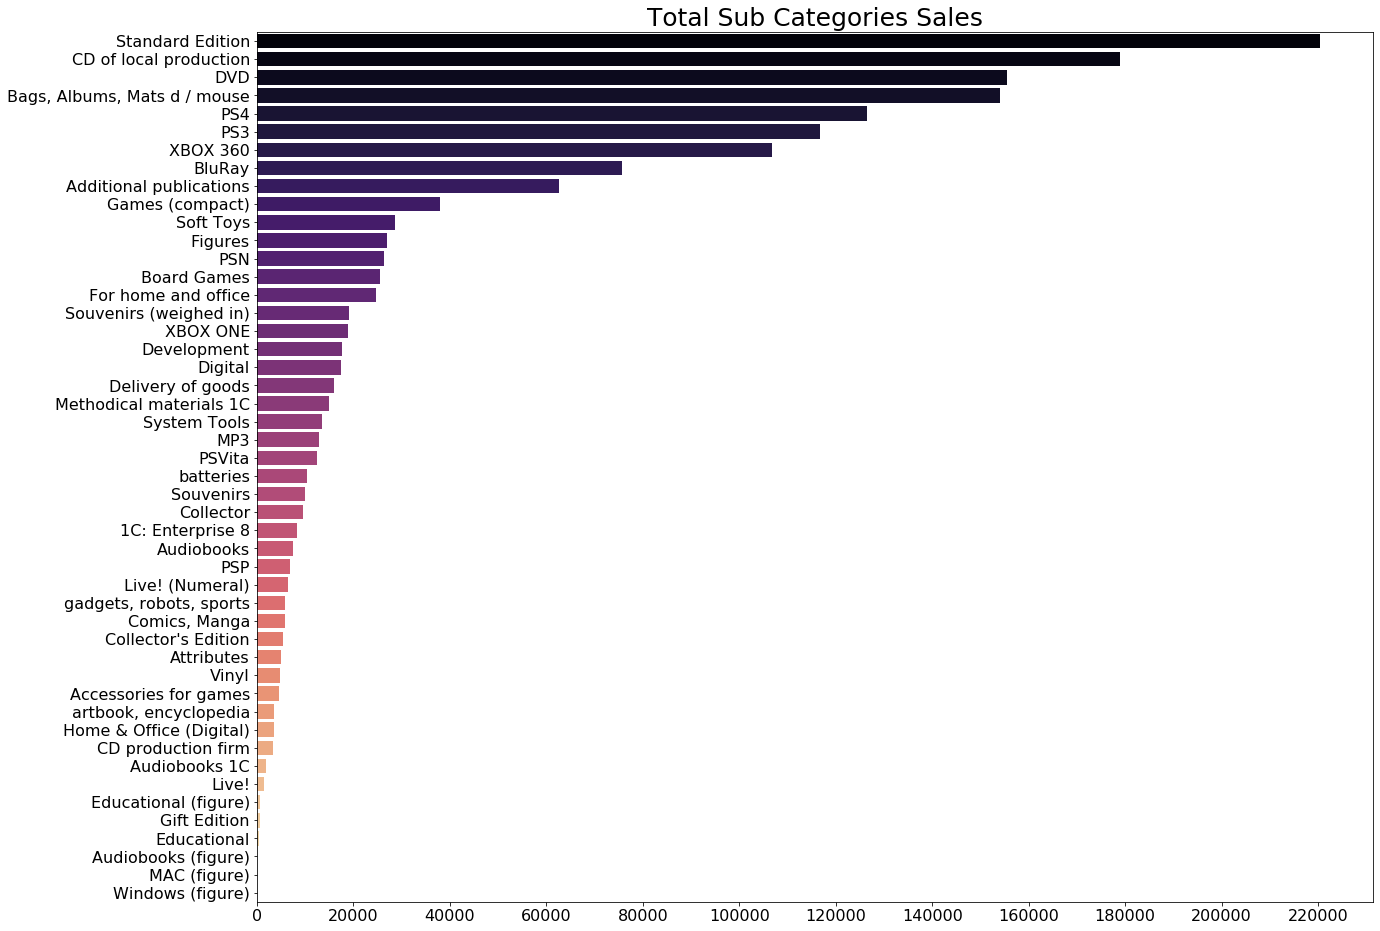

In [0]:
Z = merge1_Nodummies.groupby('category_subtype').agg({'item_cnt_month': sum}).sort_values(by='item_cnt_month',ascending=False).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,16))
sns.barplot(data=Z, x='item_cnt_month', y='category_subtype', palette="magma",orient='h')
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlabel('')
plt.title('Total Sub Categories Sales', fontsize=25)
plt.xticks([i for i in range(0, 240000, 20000)], fontsize=16);

--------------------

Monthly Sales per city 

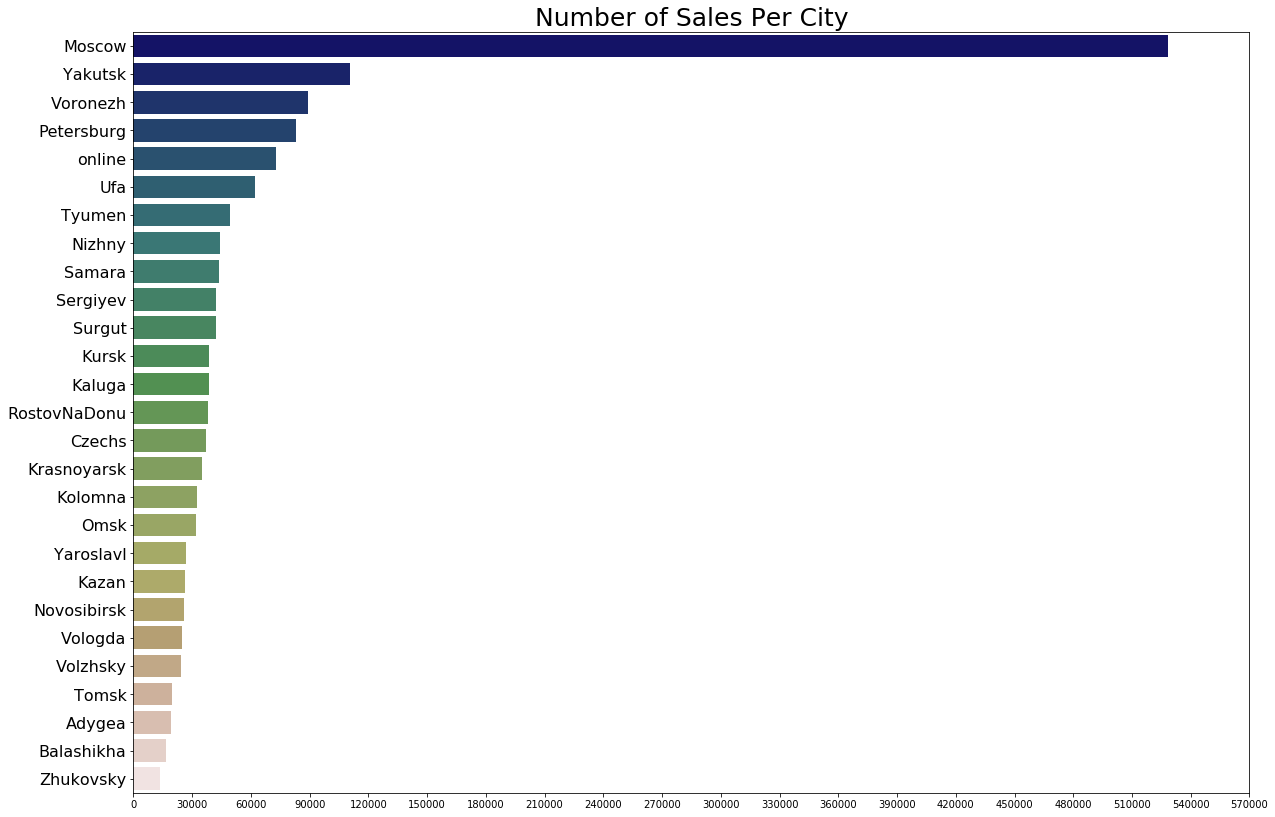

In [0]:
Z = merge1_Nodummies.groupby('city').agg({'item_cnt_month': sum}).sort_values('item_cnt_month', ascending=False).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,14))
sns.barplot(data=Z, x='item_cnt_month', y='city', palette="gist_earth",orient='h')
plt.ylabel('')
plt.xlabel('')
plt.title('Number of Sales Per City', fontsize=25)
plt.yticks(fontsize=16)
plt.xticks([i for i in range(0, 600000, 30000)]);

--------------------

This graph shows change of sales per month 



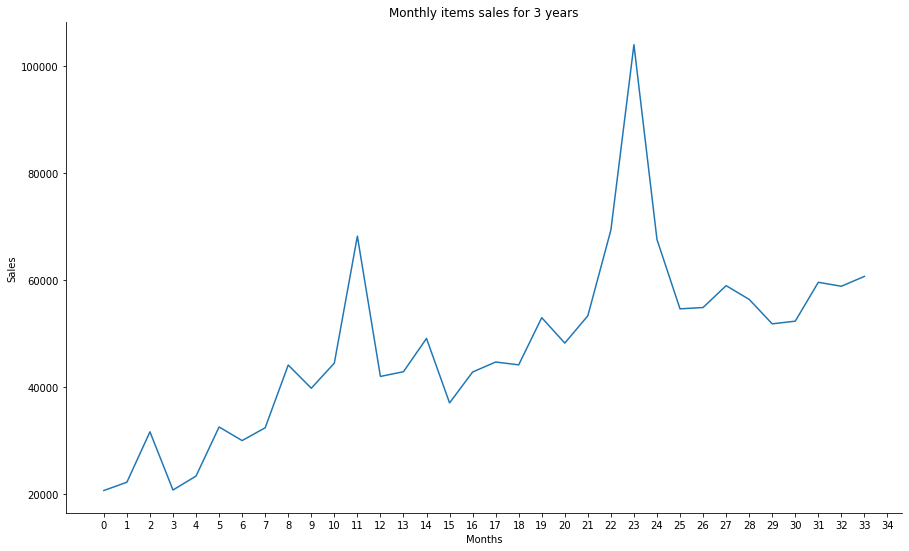

In [0]:
p = merge1_Nodummies.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index() 
g = sns.relplot(x="date_block_num", y="item_cnt_month",palette=["b", "r"], ci=None, kind="line", data=p)
g.fig.set_size_inches(15,8)
plt.title('Monthly items sales for 3 years')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.xticks([i for i in range(0, 35)]);

--------------------

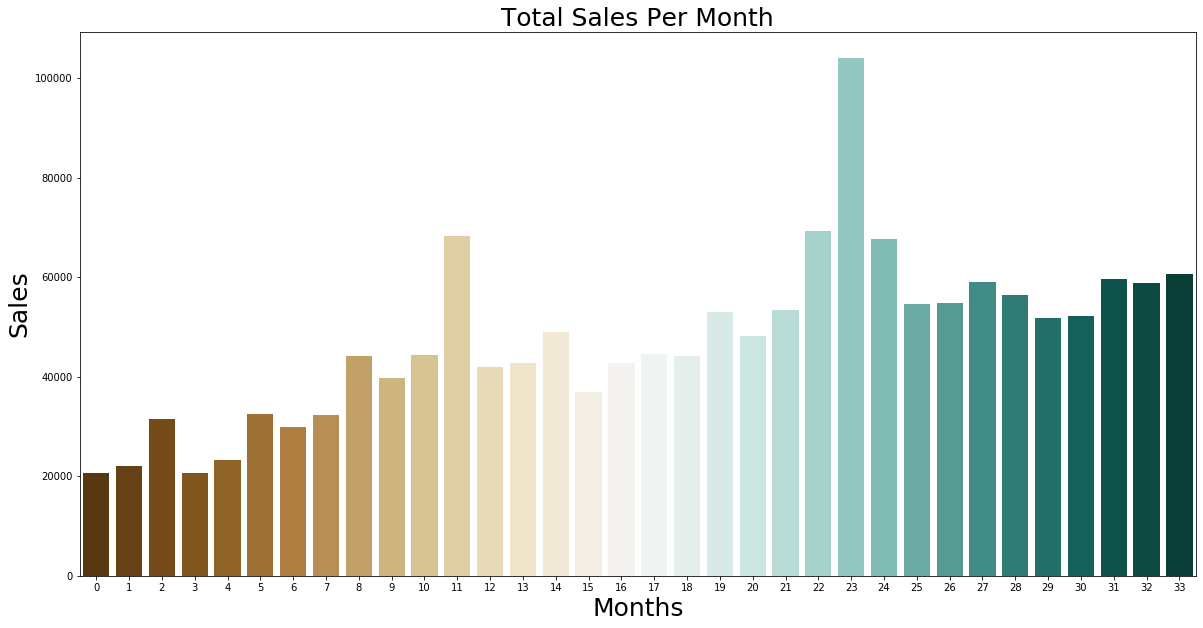

In [0]:
Z = merge1_Nodummies.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,10))
sns.barplot(data=Z, x='date_block_num', y='item_cnt_month', ax = ax, palette="BrBG")
plt.title('Total Sales Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Sales', fontsize=25);

--------------------

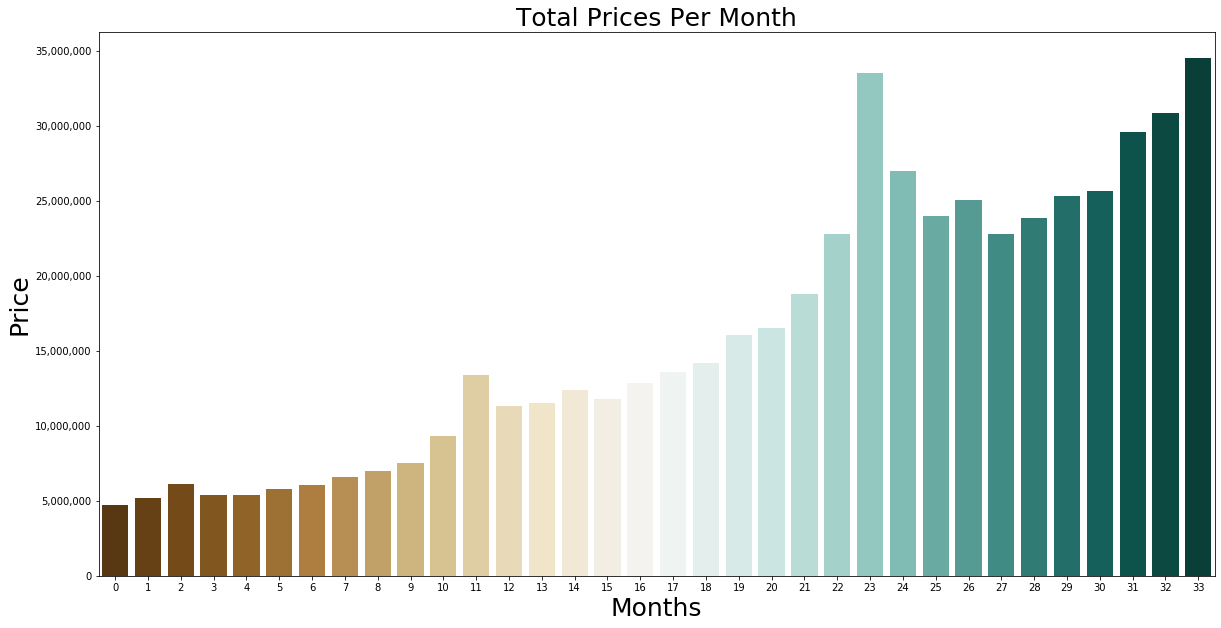

In [0]:
Z = merge1_Nodummies.groupby('date_block_num').agg({'item_avg_item_price': sum}).reset_index()
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(data=Z, x='date_block_num', y='item_avg_item_price', ax = ax, palette="BrBG")
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.title('Total Prices Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Price', fontsize=25);

--------------------

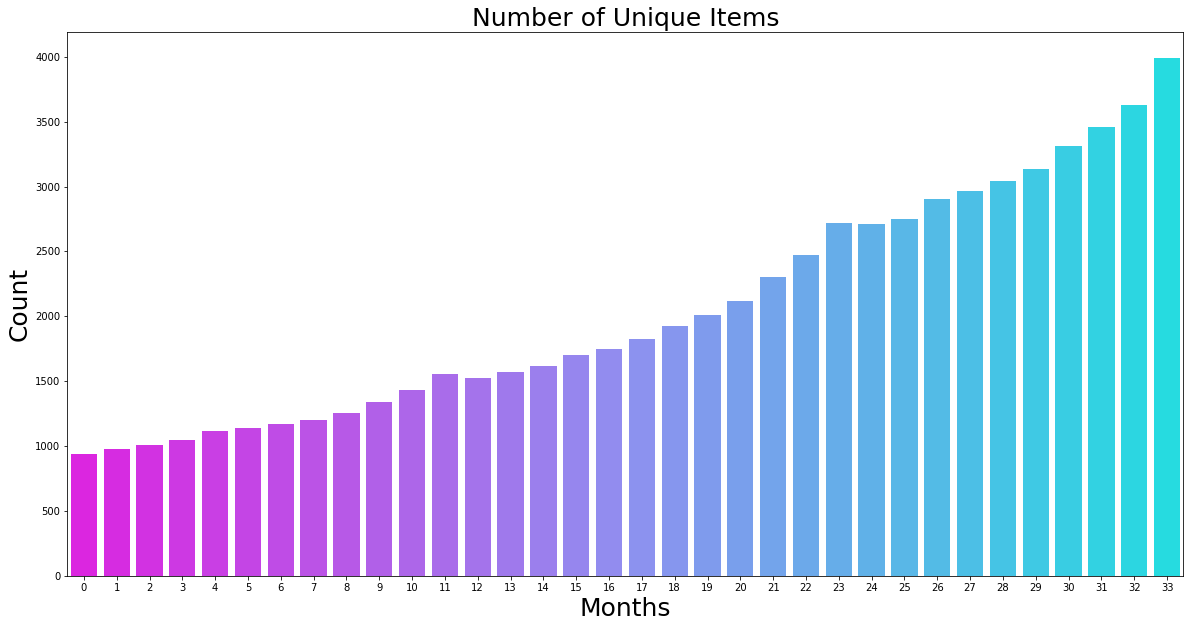

In [0]:
Z = merge1.groupby('date_block_num').agg({'item_id': 'nunique'}).reset_index()
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(data=Z, x='date_block_num', y='item_id', ax = ax, palette="cool_r")
plt.title('Number of Unique Items', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Count', fontsize=25);

--------------------

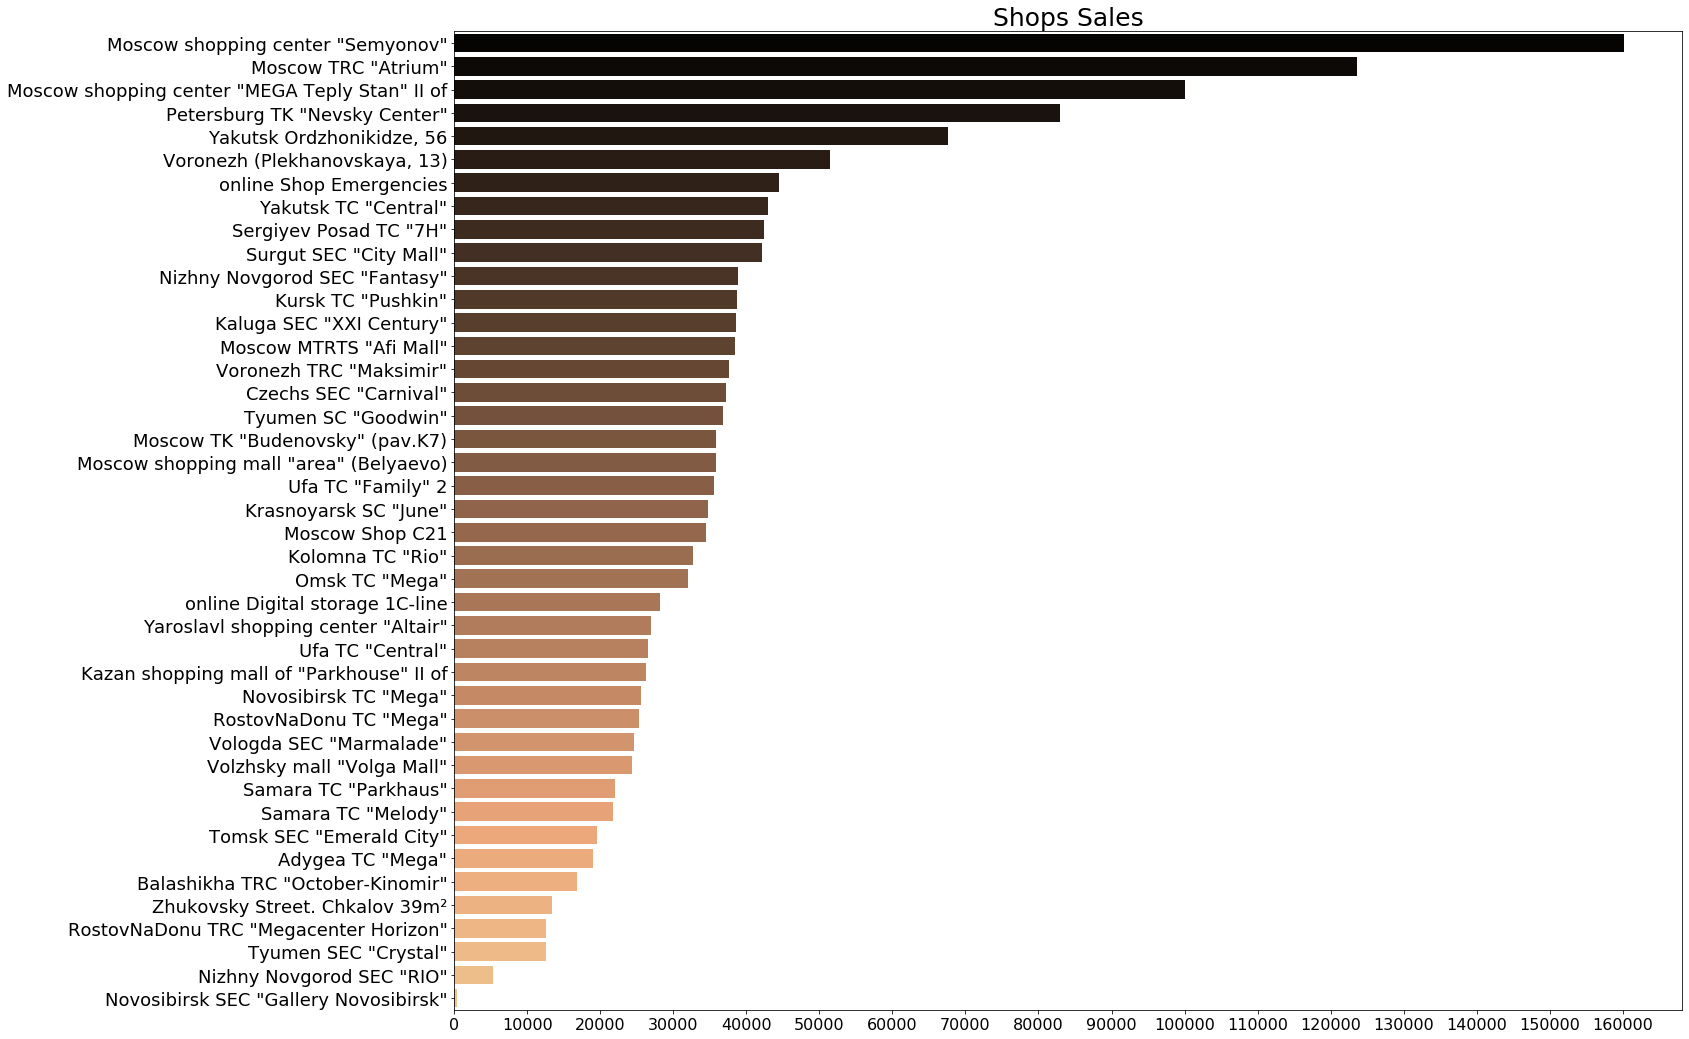

In [0]:
Z = merge1_Nodummies.groupby('shop_name').agg({'item_cnt_month': sum})\
    .sort_values(by='item_cnt_month', ascending=False).reset_index()
fig, ax = plt.subplots(figsize = (22,18))
sns.barplot(data=Z, x='item_cnt_month', y='shop_name', palette="copper",orient='h', ax=ax)
plt.title('Shops Sales', fontsize=25)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=18)
plt.xticks([i for i in range(0, 170000, 10000)], fontsize=16);

--------------------

<a id='the_destination_9'></a>
# 9. Dummies
##### Creating Dummies For Categorical Columns.

In [0]:
merge1 = pd.get_dummies(merge1, columns=['city','category_type','category_subtype'],drop_first=True)

to save memory uncomment the cell below , which will delete unneeded variables

In [0]:
# del df_catog
# del df_items
# del df_shops
# del df_sales_train0
# del merge2
# del merge1_Nodummies

In [0]:
merge1.isnull().sum().sort_values().tail(10)

gdp                                              0
city_Balashikha                                  0
item_last_sale                                   0
category_subtype_gadgets, robots, sports         0
item_avg_item_price                          15246
shop_avg_revenue                             71981
date_item_avg_item_price                    214200
delta_revenue                               281081
date_shop_revenue                           281081
delta_revenue_lag_1                         466910
dtype: int64

drop unnecessary columns

In [0]:
merge1.drop([
             'date_shop_cat_avg_item_cnt' ,
             'date_avg_item_cnt' ,
             'date_item_avg_item_cnt',
             'date_shop_avg_item_cnt',
             'date_cat_avg_item_cnt','shop_name',
             'ID',
             'item_avg_item_price',
             'date_item_avg_item_price',
             'date_shop_revenue',
             'shop_avg_revenue',
             'delta_revenue',
             'delta_revenue_lag_1'
             ], axis=1, inplace=True)

we will remove first 12 months because we are using 12 as lag

In [0]:
merge1 = merge1[merge1['date_block_num'] > 11]

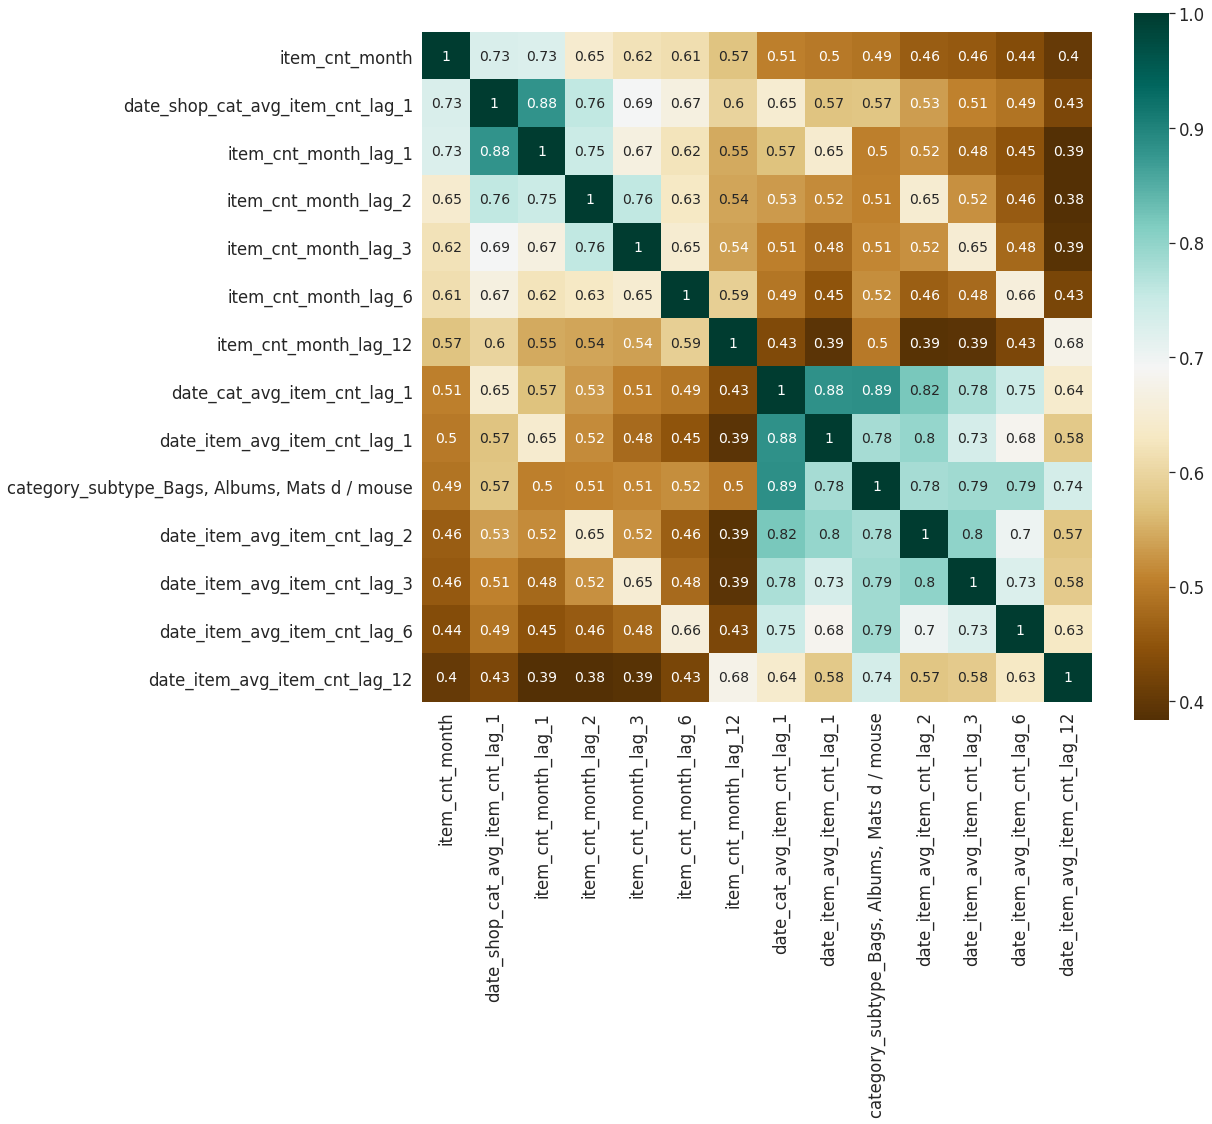

In [0]:
# Top Correlations

percent=0.20 
cor_train=merge1.corr()
high_corre = cor_train.index[abs(cor_train["item_cnt_month"])>percent]

#to sort columns from highest correlation with item_cnt_month
sorted_cols = cor_train.nlargest(len(high_corre),
'item_cnt_month')['item_cnt_month'].index 

plt.figure(figsize=(15,13))
sns.set(font_scale=1.5)

#plot heatmap with only the top features
nr_corr_matrix = sns.heatmap(merge1[sorted_cols].corr(),
annot=True,cmap="BrBG",square=True, annot_kws={'size':14})

Our data is too big so to save memory and modeling time we will change types for all columns 

In [0]:
for col in merge1.columns:
    if col == 'date_shop_revenue':
        merge1[col] = merge1[col].astype('float64')
    elif col == 'item_cnt_month':
        merge1[col] = merge1[col].astype('float32')
    elif merge1[col].dtype == 'float64':
        merge1[col] = merge1[col].astype('float16')
    elif col == 'item_id':
        merge1[col] = merge1[col].astype('int16')
    elif merge1[col].dtype == 'int64':
        merge1[col] = merge1[col].astype('int8')

In [0]:
merge1.isnull().sum().sort_values().tail(10)

city_Kazan                                  0
city_Kaluga                                 0
city_Czechs                                 0
city_Balashikha                             0
gdp                                         0
item_first_sale                             0
item_shop_first_sale                        0
item_last_sale                              0
days                                        0
category_subtype_gadgets, robots, sports    0
dtype: int64

<a id='the_destination_10'></a>

# 10. Modeling

In the evaluation section from the data provider they stated that the target in the test data is clipped to (0,20) so we did the same thing in the train data to get better results, we tried modeling without clipping and the results were bad, it seems clipping is better at handling outliers <br>
**Reference:** https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview/evaluation
 

In [0]:
merge1['item_cnt_month'] = merge1['item_cnt_month'].clip(0,20)

In [0]:
X_plot= merge1[merge1['date_block_num'] < 34]

In [0]:
X = merge1[merge1['date_block_num'] < 34].drop(['item_cnt_month', 'item_name'], axis=1)
y = merge1[merge1['date_block_num']< 34]['item_cnt_month']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.1, random_state = 42)

In [0]:
testing = merge1[merge1['date_block_num'] == 34].drop(['item_cnt_month', 'item_name'], axis=1)

In [0]:
del X
del y
del Z
del cor_train
del pie_fig
del sub_pie
del p
# del cache
# del agg
# del df_sales_train

In [17]:
import gc
gc.collect()

22

### Best Submission parameters

In [0]:
# test size = .1
# shuffle = True
# random_state =42 
# xgboost version = '1.1.0'
# google colab

##### Model
# ts = time.time()

# xgb_model = xgb.XGBRegressor(eta=0.01,
#                                  max_depth=11,n_estimators=1400,
#                                  alpha=2,
#                                  n_jobs=-1,
#                                  tree_method='gpu_hist'
#                                  )

# xgb_hist = xgb_model.fit(X_train,y_train,
#                          eval_set=[(X_train,y_train),(X_test,y_test)],
#                          eval_metric='rmse',
#                          early_stopping_rounds=10)

# time.time() - ts

# results:
# [0]	validation_0-rmse:1.54692	validation_1-rmse:1.52665
# [1399]	validation_0-rmse:0.73776	validation_1-rmse:0.88586
# Train Score: 0.7750457101368959
# Test Score : 0.6667570149949471
# Kaggle Score 0.90080

<a id='the_destination_10.1'></a>

### 10.1 Xgboost

In [16]:
ts = time.time()

xgb_model = xgb.XGBRegressor(eta=0.01,
                                 max_depth=11,n_estimators=1400,
                                 alpha=2,
                                 n_jobs=-1,
                                 tree_method='gpu_hist'
                                 )

xgb_hist = xgb_model.fit(X_train,y_train,
                         eval_set=[(X_train,y_train),(X_test,y_test)],
                         eval_metric='rmse',
                         early_stopping_rounds=10)


# tree_method='gpu_hist', gpu_id=0
time.time() - ts

[0]	validation_0-rmse:1.54692	validation_1-rmse:1.52665
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.53793	validation_1-rmse:1.51834
[2]	validation_0-rmse:1.52909	validation_1-rmse:1.51020
[3]	validation_0-rmse:1.52033	validation_1-rmse:1.50211
[4]	validation_0-rmse:1.51172	validation_1-rmse:1.49418
[5]	validation_0-rmse:1.50322	validation_1-rmse:1.48637
[6]	validation_0-rmse:1.49482	validation_1-rmse:1.47863
[7]	validation_0-rmse:1.48654	validation_1-rmse:1.47104
[8]	validation_0-rmse:1.47838	validation_1-rmse:1.46354
[9]	validation_0-rmse:1.47033	validation_1-rmse:1.45613
[10]	validation_0-rmse:1.46236	validation_1-rmse:1.44888
[11]	validation_0-rmse:1.45449	validation_1-rmse:1.44171
[12]	validation_0-rmse:1.44672	validation_1-rmse:1.43460
[13]	validation_0-rmse:1.43904	validation_1-rmse:1.42766
[14]	validation_0-rmse:1.43150	validation_1-rmse:1.42

KeyboardInterrupt: ignored

In [0]:
y_predV = xgb_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_predV)))
y_pred = xgb_model.predict(testing)

In [0]:
crxgb_model.get_params

<bound method XGBModel.get_params of XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             gpu_id=0, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=11,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=1400, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=2,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)>

In [0]:
print('Train Score:', xgb_model.score(X_train, y_train))
print('Test Score :', xgb_model.score(X_test, y_test))

Train Score: 0.7750457101368959
Test Score : 0.6667570149949471


In [0]:
# cv=KFold(n_splits=5, shuffle=True, random_state=1)
# cross_val_score(xgb_model, X, y, cv=cv).mean()

0.6023323386934785

## After testing a lot of models, and after parameters tuning, we found that XGBoost is the best model

In [0]:
features_importance = xgb_model.get_booster().get_fscore()
f_results = pd.DataFrame(features_importance.items(), columns=['feature_name', 'fscore'])
f_results.sort_values(by='fscore',ascending=False,inplace=True)
top_features = f_results['feature_name']#.head(113)
X_train[top_features]

,item_id,item_cnt_month_lag_1,delta_price_lag,shop_id,date_item_avg_item_cnt_lag_1,date_block_num,item_cnt_month_lag_2,date_shop_cat_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_1,item_cnt_month_lag_3,item_category_id,date_item_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_1,item_cnt_month_lag_6,CPI_inflation,date_shop_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,item_cnt_month_lag_12,month,date_shop_avg_item_cnt_lag_3,item_shop_first_sale,date_item_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,CPI_inflation_lag_2,CPI_inflation_lag_1,date_item_avg_item_cnt_lag_12,date_avg_item_cnt_lag_1,CPI_inflation_lag_3,item_first_sale,CPI_inflation_lag_6,days,city_Moscow,CPI_inflation_lag_12,category_subtype_PS4,city_Petersburg,city_online,category_subtype_Additional publications,category_subtype_Standard Edition,category_subtype_Games (compact),...,city_Tomsk,category_subtype_Digital,category_type_Игры,"category_subtype_Comics, Manga",category_type_Payment cards,city_Vologda,category_subtype_CD production firm,category_subtype_Figures,category_type_System Tools,category_type_Music,city_Volzhsky,category_subtype_Board Games,category_type_Books,category_subtype_PSVita,city_Balashikha,"category_subtype_artbook, encyclopedia","category_subtype_Bags, Albums, Mats d / mouse",city_Zhukovsky,category_subtype_Methodical materials 1C,category_type_Cinema,category_type_Program,category_type_Delivery of goods,category_subtype_Live!,category_subtype_Accessories for games,category_subtype_Development,category_subtype_PSN,category_subtype_For home and office,"category_subtype_gadgets, robots, sports",category_subtype_Attributes,category_subtype_MP3,category_type_Games Android,category_subtype_PSP,category_subtype_Live! (Numeral),category_subtype_Home & Office (Digital),category_type_Programs,category_subtype_Vinyl,category_subtype_Audiobooks,category_subtype_Educational,category_subtype_Audiobooks 1C,category_subtype_Gift Edition
2347598,5232,0.0,0.000000,34,0.000000,31,0.0,0.000000,0.000000,0.0,23,0.000000,0.000000,0.0,0.350098,0.000000,0.000000,0.0,7,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,31,0,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
984444,11363,0.0,0.008400,19,0.024994,18,0.0,0.869629,0.633301,0.0,75,0.024994,0.720703,0.0,0.489990,0.539062,0.024994,0.0,6,0.495605,18,0.026321,0.739746,0.612793,0.899902,0.620117,0.000000,0.611328,0.899902,18,0.589844,31,0,0.819824,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
731390,1333,0.0,0.027557,3,0.102539,15,0.0,0.000000,0.436768,0.0,58,0.052643,0.039795,0.0,0.899902,0.268555,0.000000,0.0,3,0.260254,15,0.000000,0.000000,0.172241,0.700195,1.019531,0.027771,0.776367,0.589844,15,0.000000,30,0,0.509766,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
646181,19310,0.0,0.000000,47,0.026321,14,0.0,0.000000,0.604004,0.0,54,0.052643,0.416992,0.0,1.019531,0.629883,0.052643,0.0,2,0.930664,3,0.000000,0.000000,0.000000,0.589844,0.700195,0.000000,0.717773,0.500000,3,0.000000,31,0,0.000000,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2000471,9845,2.0,-0.643066,57,0.317139,28,1.0,1.492188,0.741211,1.0,40,0.268311,0.412842,1.0,0.350098,0.734863,0.300049,0.0,4,0.896973,14,0.438965,0.890137,1.092773,1.209961,0.459961,0.975098,0.484863,2.220703,14,1.280273,31,0,0.899902,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249612,9526,0.0,0.304932,41,0.048767,21,0.0,0.000

In [0]:
top_features

4                             item_id
0                item_cnt_month_lag_1
44                    delta_price_lag
12                            shop_id
29       date_item_avg_item_cnt_lag_1
                    ...              
100            category_type_Programs
110            category_subtype_Vinyl
108       category_subtype_Audiobooks
111      category_subtype_Educational
113    category_subtype_Audiobooks 1C
Name: feature_name, Length: 113, dtype: object

In [0]:
ts = time.time()

xgb_model1 = xgb.XGBRegressor(eta=0.01,
                                 max_depth=10,n_estimators=1600,
                                 alpha=2,
                                 n_jobs=-1,
                                 tree_method='gpu_hist'
                                 )

xgb_hist1 = xgb_model1.fit(X_train[top_features],y_train,
                         eval_set=[(X_train[top_features],y_train),(X_test[top_features],y_test)],
                         eval_metric='rmse',
                         early_stopping_rounds=10)


# tree_method='gpu_hist', gpu_id=0
time.time() - ts

[0]	validation_0-rmse:1.54727	validation_1-rmse:1.52690
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.53866	validation_1-rmse:1.51883
[2]	validation_0-rmse:1.53019	validation_1-rmse:1.51090
[3]	validation_0-rmse:1.52180	validation_1-rmse:1.50306
[4]	validation_0-rmse:1.51353	validation_1-rmse:1.49526
[5]	validation_0-rmse:1.50536	validation_1-rmse:1.48761
[6]	validation_0-rmse:1.49731	validation_1-rmse:1.48013
[7]	validation_0-rmse:1.48935	validation_1-rmse:1.47269
[8]	validation_0-rmse:1.48153	validation_1-rmse:1.46544
[9]	validation_0-rmse:1.47381	validation_1-rmse:1.45819
[10]	validation_0-rmse:1.46621	validation_1-rmse:1.45114
[11]	validation_0-rmse:1.45871	validation_1-rmse:1.44414
[12]	validation_0-rmse:1.45132	validation_1-rmse:1.43722
[13]	validation_0-rmse:1.44403	validation_1-rmse:1.43045
[14]	validation_0-rmse:1.43685	validation_1-rmse:1.42

364.20264887809753

In [0]:
y_predV = xgb_model1.predict(X_test[top_features])
print(np.sqrt(mean_squared_error(y_test, y_predV)))
y_pred = xgb_model1.predict(testing[top_features])

0.8955706


## Visualizing XGBoost results

In [0]:
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

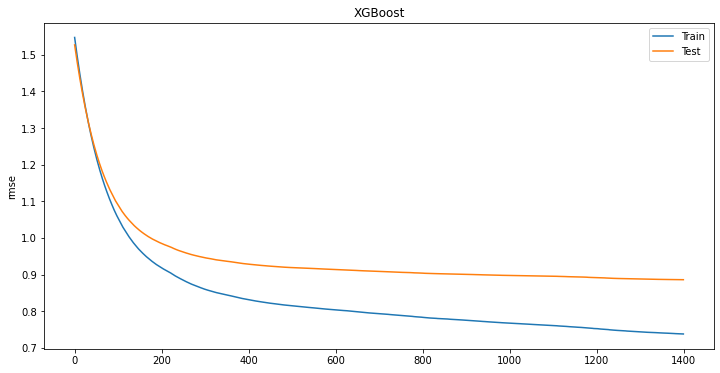

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost')
plt.show()

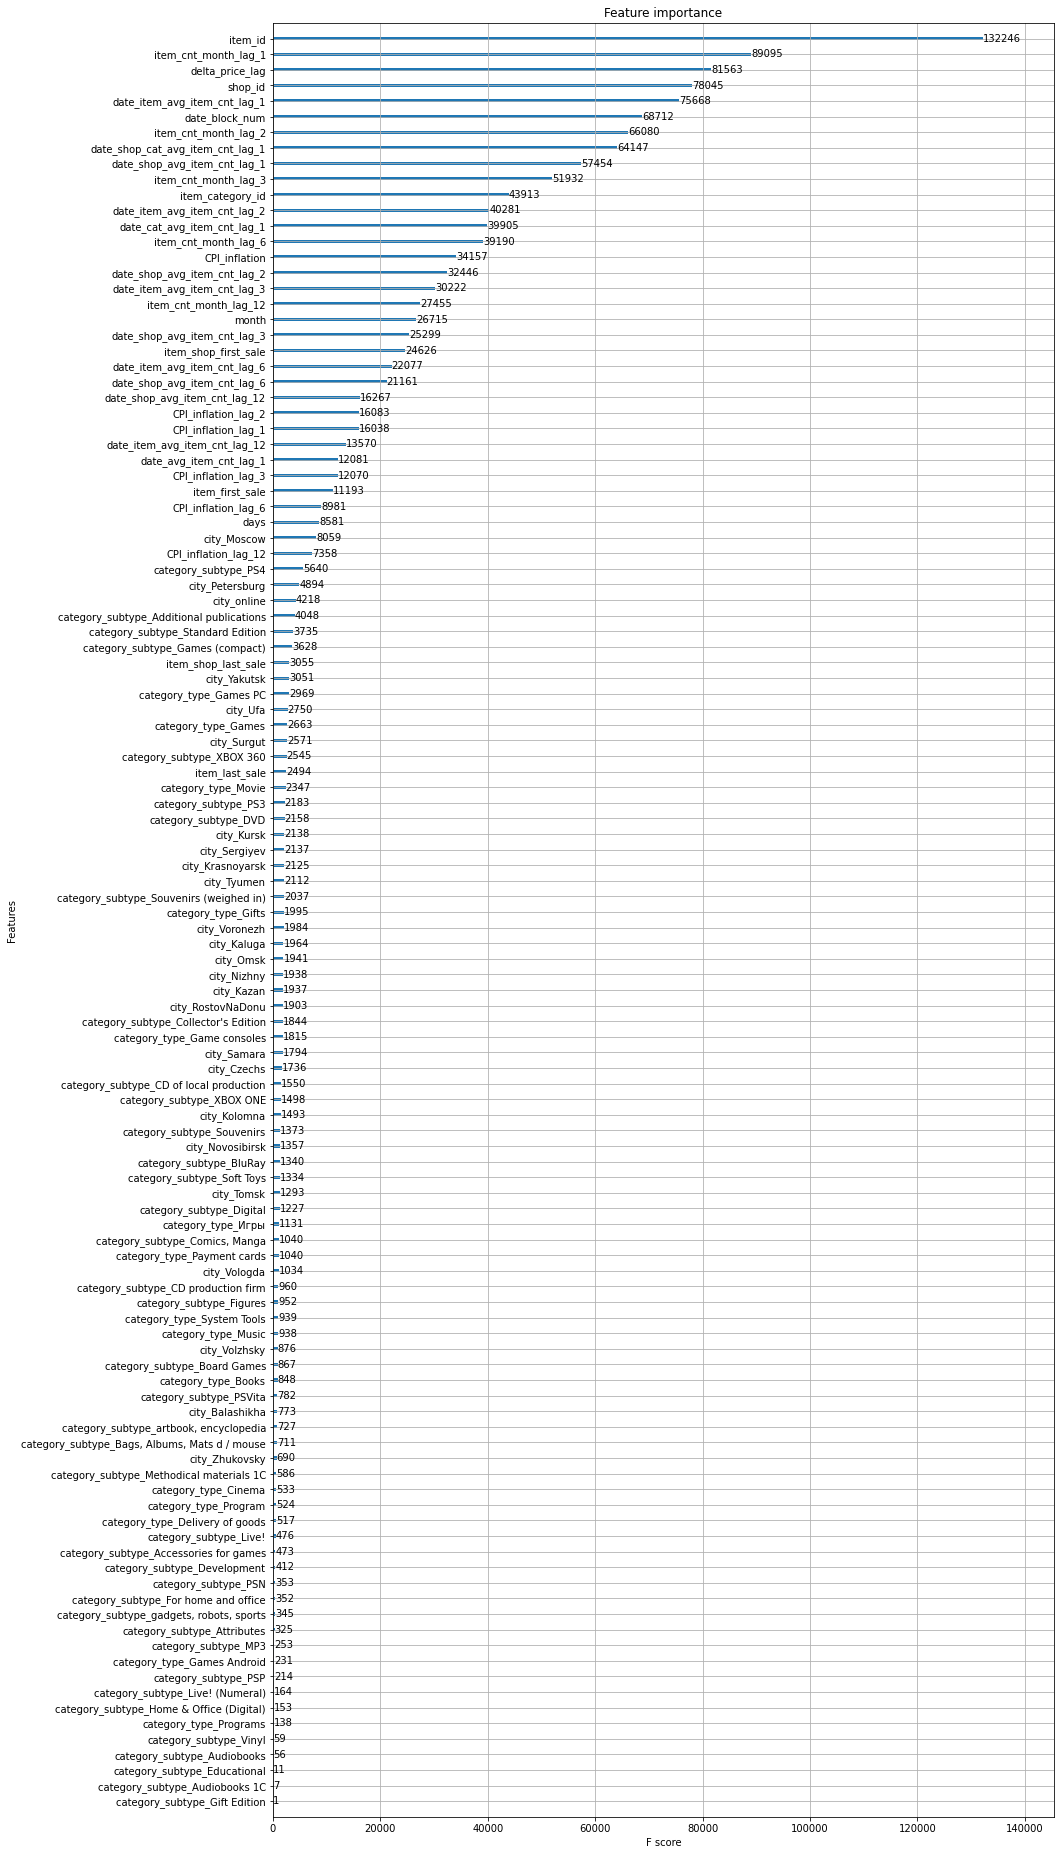

In [0]:
fig, ax = plt.subplots(figsize=(14,33))
xgb.plot_importance(xgb_model, ax);

Here are the predicted top 10 items we expect to have high sales in the next month

In [0]:
#here we will get item_name from date_block_number 33 (month 33) 
y_predV_Df_test = pd.DataFrame({'item_id' : X_test['item_id'],'shop_id' : X_test['shop_id'] ,'item_cnt_month' : y_predV  }) 
top_10_items = y_predV_Df_test.sort_values(by='item_cnt_month' , ascending=False).head(20)
top_10_items['date_block_num'] = 33 
item_name = []
for i in top_10_items['item_id'].values:
    
    top = pd.merge(top_10_items,merge1[['item_name' , 'item_id','shop_id','date_block_num']],on=['item_id','shop_id','date_block_num'],how='left')#
    
top['date_block_num'] = 34

In [0]:
top.head(10)

,item_id,shop_id,item_cnt_month,date_block_num,item_name
0,6503,28,22.135168,34,"Sims 4 [PC, Russian version]"
1,3340,6,21.610468,34,"FIFA 15 [PC, Russian version]"
2,7807,25,20.769270,34,NaN
3,5822,31,20.618273,34,Playstation Store replenishment wallet: Map pa...
4,492,55,20.582348,34,"1С:Деньги 8 Электронная версия [PC, Цифровая в..."
5,7805,31,20.524818,34,"Watch_Dogs. Special edition [PC, Russian version]"
6,11354,42,20.512018,34,"Living till dawn. Extended Edition [PS4, Russi..."
7,5822,28,20.453493,34,Playstation Store replenishment wallet: Map pa...
8,1556,31,20.440218,34,"Assassin's Creed: Unity. Special edition [PS4,..."
9,11373,12,20.410776,34,Delivery to the delivery point (Boxberry)


### Compairing the actual values with predicted values

In [0]:
y_predV_Df = pd.DataFrame({'date_block_num' : X_test['date_block_num'] ,'item_cnt_month' : y_predV  })

In [0]:
y_test_Df = pd.DataFrame({'date_block_num' : X_test['date_block_num'] ,'item_cnt_month' : y_test  })

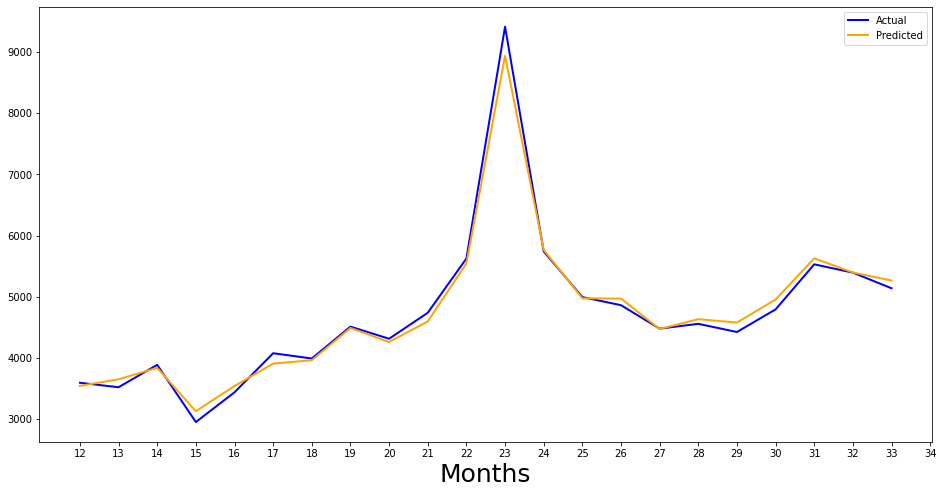

In [0]:
fig , ax = plt.subplots(ncols=1 , figsize=(16,8))
xl = y_test_Df.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
y_predsum = y_predV_Df.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
xl.plot(x='date_block_num',y='item_cnt_month' , kind='line' , ax=ax ,  linewidth=2 , c='b')
y_predsum.plot(x='date_block_num',y='item_cnt_month' , kind='line' , ax=ax , linewidth=2 , c='orange' )
plt.legend(['Actual' , 'Predicted'])
plt.xlabel('Months' , fontsize=25)
# y_predsum.plot(x='date_block_num',y='item_cnt_month', kind='line' , ax=ax)
ax.set_xticks([i for i in range(12, 35)]);
# ax.set_yticks([i for i in range(0, 20000, 3000)]);

### Ploting the train and predicted test

In [0]:
y_predDf = pd.DataFrame({'date_block_num' : 34 ,'item_cnt_month' : y_pred  })
y_predsum = y_predDf.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
xl = X_plot.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
mk = pd.concat([xl, y_predsum])

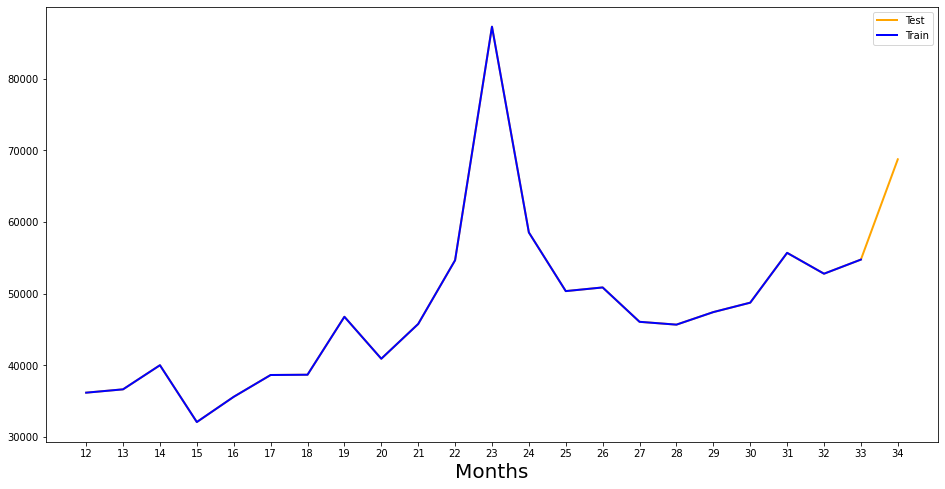

In [0]:
fig , ax = plt.subplots(ncols=1 , figsize=(16,8))
xl = X_plot.groupby('date_block_num').agg({'item_cnt_month': sum}).reset_index()
mk.plot(x='date_block_num',y='item_cnt_month' , kind='line' , ax=ax ,  linewidth=2 , c='orange')
xl.plot(x='date_block_num',y='item_cnt_month' , kind='line' , ax=ax , linewidth=2 , c='b' )
ax.legend(['Test' , 'Train'])
plt.xlabel('Months' , fontsize=20)
ax.set_xticks([i for i in range(12, 35)]);

### also Ploting the train and predicted test

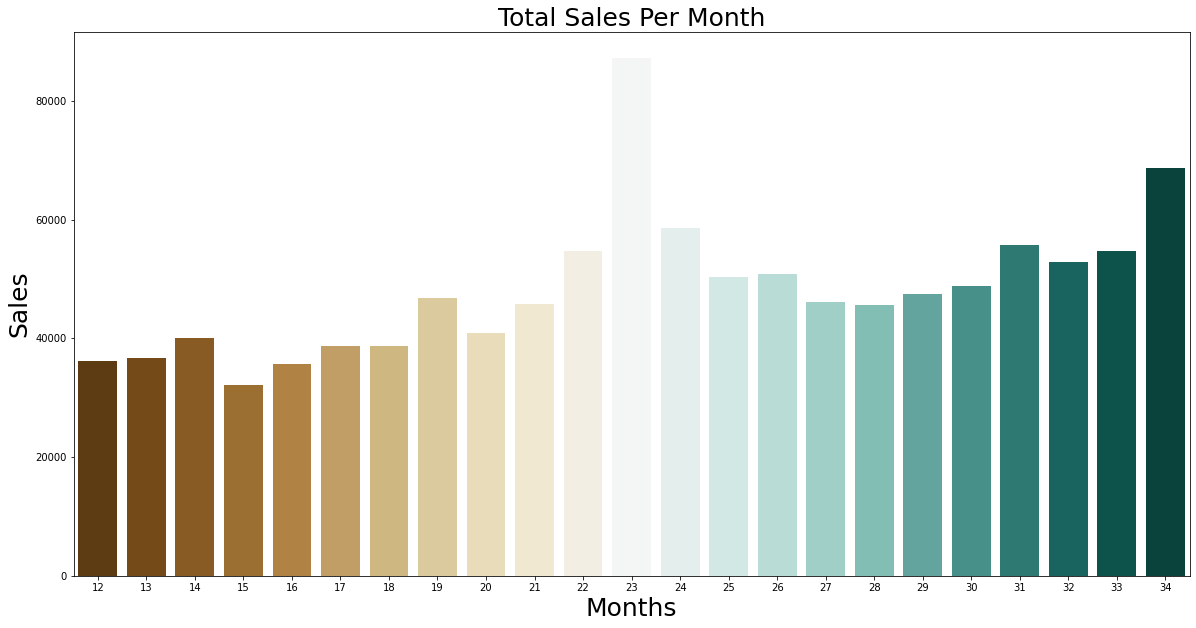

In [0]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(data=mk, x='date_block_num', y='item_cnt_month', ax = ax, palette="BrBG")
plt.title('Total Sales Per Month', fontsize=25)
plt.xlabel('Months', fontsize=25)
plt.ylabel('Sales', fontsize=25);

<a id='the_destination_10.2'></a>

### 10.2 Sequential model

In [0]:
Seq_model = Sequential()
Seq_model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1] ))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))
Seq_model.add(Dense(50,activation='relu'))


Seq_model.add(Dense(1))

In [0]:
Seq_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 129)               16770     
_________________________________________________________________
dense_16 (Dense)             (None, 50)                6500      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_20 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_21 (Dense)             (None, 50)               

In [0]:
opt = Adam(lr=.001)

In [0]:
Seq_model.compile(loss='mse', optimizer= opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [0]:
ts = time.time()



Seq_hist = Seq_model.fit(X_train,
                          y_train,
                         validation_data = (X_test, y_test),
                         batch_size=10000,
                         epochs = 40)
time.time() - ts

Train on 2031305 samples, validate on 225701 samples
Epoch 1/40
2031305/2031305 [==============================] - 11s 5us/step - loss: 28.2200 - root_mean_squared_error: 9.6558 - val_loss: 2.9591 - val_root_mean_squared_error: 5.1797
Epoch 2/40
2031305/2031305 [==============================] - 10s 5us/step - loss: 2.1643 - root_mean_squared_error: 4.3371 - val_loss: 1.8994 - val_root_mean_squared_error: 3.7691
Epoch 3/40
2031305/2031305 [==============================] - 10s 5us/step - loss: 1.8901 - root_mean_squared_error: 3.4327 - val_loss: 1.5266 - val_root_mean_squared_error: 3.1668
Epoch 4/40
2031305/2031305 [==============================] - 9s 5us/step - loss: 3.3688 - root_mean_squared_error: 2.9931 - val_loss: 1.9398 - val_root_mean_squared_error: 2.8814
Epoch 5/40
2031305/2031305 [==============================] - 9s 5us/step - loss: 1.7317 - root_mean_squared_error: 2.7549 - val_loss: 1.5377 - val_root_mean_squared_error: 2.6411
Epoch 6/40
2031305/2031305 [===============

398.95468854904175

In [0]:
y_pred = Seq_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
y_pred = Seq_model.predict(testing)

1.183571919257938


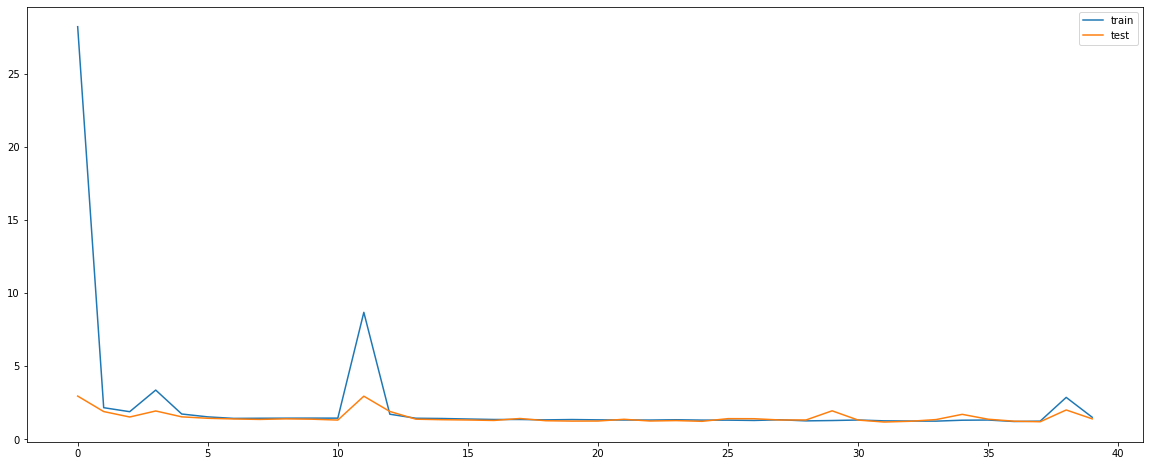

In [0]:
## plot loss function
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(Seq_hist.history['loss'], label='train')
plt.plot(Seq_hist.history['val_loss'], label='test')
plt.legend()

<a id='the_destination_10.3'></a>

### 10.3 LSTM

In [0]:
ss = StandardScaler()
sX_train =ss.fit_tranX_torm(X_train)
sX_test =ss.transform(X_test)
stesting=ss.transform(testing)

In [0]:
X_train1 = np.reshape(sX_train, (sX_train.shape[0], 1, sX_train.shape[1]))
X_test1 = np.reshape(sX_test, (sX_test.shape[0], 1, sX_test.shape[1]))

In [0]:
lstm_model = Sequential()
lstm_model.add(LSTM(X_train.shape[1], input_dim=X_train.shape[1]))
lstm_model.add(Dense(150))
lstm_model.add(Dense(150))
lstm_model.add(Dense(150))
lstm_model.add(Dense(150))
lstm_model.add(Dense(1))


lstm_model.compile(loss='mse', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [0]:
ts = time.time()

lstm_model.fit(X_train1, y_train,
               validation_data=(X_test1, y_test),
               epochs=50,
               shuffle=False,
               batch_size=4000,
               verbose=1)
time.time() - ts

Train on 2031305 samples, validate on 225701 samples
Epoch 1/50
2031305/2031305 [==============================] - 26s 13us/step - loss: 1.2281 - root_mean_squared_error: 1.1679 - val_loss: 1.1798 - val_root_mean_squared_error: 1.1070
Epoch 2/50
2031305/2031305 [==============================] - 26s 13us/step - loss: 1.1240 - root_mean_squared_error: 1.0941 - val_loss: 1.1367 - val_root_mean_squared_error: 1.0840
Epoch 3/50
2031305/2031305 [==============================] - 26s 13us/step - loss: 1.0926 - root_mean_squared_error: 1.0774 - val_loss: 1.1058 - val_root_mean_squared_error: 1.0715
Epoch 4/50
2031305/2031305 [==============================] - 24s 12us/step - loss: 1.0710 - root_mean_squared_error: 1.0669 - val_loss: 1.0819 - val_root_mean_squared_error: 1.0626
Epoch 5/50
2031305/2031305 [==============================] - 25s 12us/step - loss: 1.0544 - root_mean_squared_error: 1.0590 - val_loss: 1.0669 - val_root_mean_squared_error: 1.0557s: 1.0553 - root_mean_squared_error: 1

Epoch 45/50
2031305/2031305 [==============================] - 26s 13us/step - loss: 0.8495 - root_mean_squared_error: 0.9754 - val_loss: 0.9576 - val_root_mean_squared_error: 0.9749
Epoch 46/50
2031305/2031305 [==============================] - 26s 13us/step - loss: 0.8470 - root_mean_squared_error: 0.9744 - val_loss: 0.9597 - val_root_mean_squared_error: 0.9739
Epoch 47/50
2031305/2031305 [==============================] - 25s 12us/step - loss: 0.8448 - root_mean_squared_error: 0.9734 - val_loss: 0.9612 - val_root_mean_squared_error: 0.9729
Epoch 48/50
2031305/2031305 [==============================] - 24s 12us/step - loss: 0.8422 - root_mean_squared_error: 0.9724 - val_loss: 0.9619 - val_root_mean_squared_error: 0.9719
Epoch 49/50
2031305/2031305 [==============================] - 25s 12us/step - loss: 0.8398 - root_mean_squared_error: 0.9714 - val_loss: 0.9622 - val_root_mean_squared_error: 0.9709
Epoch 50/50
2031305/2031305 [==============================] - 24s 12us/step - loss: 

1236.8428268432617

In [0]:
testing1 = np.reshape(stesting, (stesting.shape[0], 1, stesting.shape[1]))

In [0]:
y_pred = lstm_model.predict(X_test1)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
y_pred = lstm_model.predict(testing1)

0.9787841087700061


<a id='the_destination_10.4'></a>

### 10.4 Random Forest Regressor Model

In [0]:
randomF = RandomForestRegressor(verbose=1 , n_jobs=-1)
randomF.fit(X_train[top_features], y_train)
print('Train Score:', randomF.score(X_train[top_features], y_train))
print('Test Score :', randomF.score(X_test[top_features], y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 31.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   32.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Train Score: 0.9525040560901875


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s


Test Score : 0.6517129876233431


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.6s finished


In [0]:
y_pred = randomF.predict(X_test[top_features])
print(np.sqrt(mean_squared_error(y_test, y_pred)))
y_pred = randomF.predict(testing[top_features])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


0.9056337987489868


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


<a id='the_destination_10.5'></a>

### 10.5 LinearRegression

In [0]:
ts = time.time()
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)
print('Train Score:',lr.score(X_train, y_train))
print('Test Score :',lr.score(X_test, y_test))
time.time() - ts

Train Score: 0.3236789283472482
Test Score : 0.2753002853891804


9.999837875366211

In [0]:
y_pred = lr.predict(X_test).clip(0, 20)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
y_pred = lr.predict(testing).clip(0, 20)

1.244300825618995


*italicized text*<a id='the_destination_10.6'></a>

## 10.6 Ridge

In [0]:
ts = time.time()
ridge = Ridge()
ridge.fit(X_train, y_train)
print('Train Score:', ridge.score(X_train, y_train))
print('Test Score :', ridge.score(X_test, y_test))
time.time() - ts

Train Score: 0.3249283458315415
Test Score : 0.2765395263467689


3.430891275405884

In [0]:
y_pred = ridge.predict(X_test).clip(0, 20)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
y_pred = ridge.predict(testing).clip(0, 20)

1.244293353333927


## Lasso

In [0]:
ts = time.time()
lasso = Lasso()
lasso.fit(X_train[top_features], y_train)
print('Train Score:', lasso.score(X_train[top_features], y_train))
print('Test Score :', lasso.score(X_test[top_features], y_test))
time.time() - ts

Train Score: 0.14040003018172142
Test Score : 0.14262541498988657


3.9051320552825928

## lightgbm

In [0]:
# import lightgbm as lgb

# ts = time.time()
# train_data = lgb.Dataset(data=X_train, label=y_train)
# valid_data = lgb.Dataset(data=X_test, label=y_test)

# time.time() - ts
    
# params = {'num_leaves': 2000, 'max_depth': 19, 'max_bin': 107, 'n_estimators': 1100,
#           'bagging_freq': 1, 'bagging_fraction': 0.7135681370918421, 
#           'feature_fraction': 0.49446461478601994, 'min_data_in_leaf': 88, 
#           'learning_rate': 0.01, 'num_threads': 3, 
#           'min_sum_hessian_in_leaf': 6,
         
#           'verbosity' : 1,
#           'boost_from_average' : 'true',
#           'boost' : 'gbdt',
#           'metric' : 'rmse',}
# lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1, num_boost_round=20)

############################################
# Kaggle Score : 0.90560
# [1]	training's rmse: 1.54864	valid_1's rmse: 1.52789
# [1100]	training's rmse: 0.809505	valid_1's rmse: 0.887232

In [0]:
import lightgbm as lgb

ts = time.time()
train_data = lgb.Dataset(data=X_train, label=y_train)
valid_data = lgb.Dataset(data=X_test, label=y_test)

time.time() - ts
    
# params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':2000, 'early_stopping_rounds':10, "learning_rate" : 0.01}
params = {'num_leaves': 2000, 'max_depth': 19, 'max_bin': 107, 'n_estimators': 900,
          'bagging_freq': 1, 'bagging_fraction': 0.7135681370918421, 
          'feature_fraction': 0.49446461478601994, 'min_data_in_leaf': 88, 
          'learning_rate': 0.01, 'num_threads': 3, 
          'min_sum_hessian_in_leaf': 6,
         
          # 'random_state' : RANDOM_SEED,
          'verbosity' : 1,
          # 'bagging_seed' : RANDOM_SEED,
          'boost_from_average' : 'true',
          'boost' : 'gbdt',
          'metric' : 'rmse',}
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1, num_boost_round=20)

[1]	training's rmse: 1.54864	valid_1's rmse: 1.52789
[2]	training's rmse: 1.54046	valid_1's rmse: 1.51994
[3]	training's rmse: 1.53265	valid_1's rmse: 1.51234
[4]	training's rmse: 1.5267	valid_1's rmse: 1.50663
[5]	training's rmse: 1.51882	valid_1's rmse: 1.49906
[6]	training's rmse: 1.5109	valid_1's rmse: 1.49145
[7]	training's rmse: 1.50321	valid_1's rmse: 1.484
[8]	training's rmse: 1.49613	valid_1's rmse: 1.47719
[9]	training's rmse: 1.48867	valid_1's rmse: 1.47001
[10]	training's rmse: 1.48113	valid_1's rmse: 1.4627
[11]	training's rmse: 1.47363	valid_1's rmse: 1.45552
[12]	training's rmse: 1.46673	valid_1's rmse: 1.4489
[13]	training's rmse: 1.45989	valid_1's rmse: 1.44243
[14]	training's rmse: 1.45311	valid_1's rmse: 1.43595
[15]	training's rmse: 1.44577	valid_1's rmse: 1.42891
[16]	training's rmse: 1.43987	valid_1's rmse: 1.42331
[17]	training's rmse: 1.43355	valid_1's rmse: 1.41718
[18]	training's rmse: 1.42721	valid_1's rmse: 1.41112
[19]	training's rmse: 1.42052	valid_1's rms

In [0]:
y_predV = lgb_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_predV)))
y_pred = lgb_model.predict(testing)

0.8910314912678312


<a id='the_destination_11'></a>

## 11. Submission

In [0]:
thesubmission = df.copy()
thesubmission['item_cnt_month'] = y_pred.clip(0,20)
thesubmission['item_cnt_month'] += -0.045
thesubmission.to_csv('Xgboostlastone.csv', index=False)
thesubmission['item_cnt_month'].head()

0    0.708654
1    1.012632
2    1.437273
3    1.010609
4    0.709814
Name: item_cnt_month, dtype: float32

<a id='the_destination_12'></a>

# 12.Evaluation

Here submissions are evaluated by root mean squared error (RMSE). <br>
True target values are clipped into [0,20] range. <br>
<br>
Best model<br>
Model:             XGBoost<br>
Runtime:           3 Minutes<br>
kaggle Score(RMSE):       0.90


<a id='the_destination_13'></a>

# 13. Conclusion and Recommendations

After we saw that the sales well increase in November, we advise the shops to expect a lot of customers ,
also after analyzing the data we noticed that over 65% of the sales come from entertainment sector, also our model expect that 4 of the top 10 selling items in the next month will come from the entertainment sector
So we recommend shops in the entertainment sector to be ready for high demand from customers

<a id='the_destination_14'></a>

# 14. References

Datasets : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data <br>
CPI: Consumer price index : https://www.inflation.eu/inflation-rates/russia/historic-inflation/cpi-inflation-russia.aspx <br>
Russia GDP Per Capita : https://www.macrotrends.net/countries/RUS/russia/gdp-per-capita